In [1]:
import pandas as pd
import yfinance as yf
import pandas_market_calendars as mcal
from datetime import datetime
import numpy as np
import datetime
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tseries.offsets import CustomBusinessDay
from pandas.tseries.holiday import USFederalHolidayCalendar
import joblib
import stock_project_functions_SAVE as spf
import numpy as np
from scipy import stats



# Executive Summary: Outperforming the Market with Advanced Stock Selection

Our project has successfully developed a robust stock-picking strategy that consistently outperforms the market across two distinct time periods. After extensive analysis of various strategies, back periods, and holding periods, we have identified a highly effective metric for stock selection.

## Key Findings:

1. **Superior Performance**: Our strategy demonstrates consistent outperformance compared to the broader market in two separate time frames.

2. **Comprehensive Analysis**: We evaluated multiple strategies, back periods, and holding periods to identify the most effective approach.

3. **Innovative Metric**: The core of our strategy relies on a novel metric that has shown strong predictive power for stock performance.

## The Metric:

Our proprietary metric is defined as follows:

$$
\text{Metric} = \text{Slope}(\text{CumProd}) \times \text{Correlation}(\text{CumProd}, \text{Time})
$$


Where:

- $$\text{CumProd} = \prod_{t=1}^{T} \left(1 + \frac{\text{Stock}_t}{\text{ETF}_t} - 1\right)$$
- **Slope**: The slope of the cumulative product of percent changes in the stock's relative strength compared to its industry ETF.
- **Correlation**: The correlation between the cumulative product and consecutive time periods.

This metric effectively captures:
1. The trend in a stock's relative strength against its industry.
2. The consistency of this trend over time.

## Key Advantages:

1. **Predictive Power**: The metric shows a strong monotonic correlation with positive percent gains, making it a reliable indicator of future stock performance in the short term..

2. **Industry-Relative Performance**: By comparing stocks to their industry ETFs, the strategy accounts for sector-specific trends and fluctuations.

3. **Trend Consistency**: The correlation component ensures that we select stocks with sustained, rather than sporadic, outperformance.

## Implementation Strategy:

1. **Regular Rebalancing**: Apply the metric to the investment universe at predetermined intervals.
2. **Ranking System**: Rank stocks based on the calculated metric values.
3. **Portfolio Construction**: Select top-ranked stocks for inclusion in the portfolio.
4. **Risk Management**: Implement appropriate position sizing and diversification strategies.
5. **Ongoing Monitoring**: Continuously evaluate the strategy's performance and make adjustments as necessary.

This data-driven approach provides a solid foundation for constructing a portfolio with a higher probability of outperforming the market. By leveraging this innovative metric, we can identify stocks with consistent relative strength and positive momentum, potentially leading to superior long-term returns.


In [19]:
files_df=pd.read_csv('stock_data_details.csv')


print(files_df[['File_Name', 'Variable_Name']])

# Check for any remaining unmatched files
unmatched = files_df[files_df['Variable_Name'].isna()]
if not unmatched.empty:
    print("\nRemaining unmatched files:")
    print(unmatched['File_Name'])

# create variables for each file
for index, row in files_df.iterrows():
    if row['Variable_Name']:
        globals()[row['Variable_Name']] = pd.read_csv(row['File_Name'])
all_vars = list(globals().keys())

# Filter for dataframe variables (assuming they all start with 'df_')
df_vars = [var for var in all_vars if var.startswith('df_')]

for var_name in df_vars:
    # Get the dataframe
    df = globals()[var_name]
    
    # Check if it's actually a dataframe and has the required columns
    if isinstance(df, pd.DataFrame) and 'End Date' in df.columns and 'Metric' in df.columns:
        # Convert 'End Date' to datetime
        df['End Date'] = pd.to_datetime(df['End Date'])
        
        # Sort the dataframe
        df = df.sort_values(['Metric', 'End Date'])
        
        # Reassign the sorted dataframe back to the variable
        globals()[var_name] = df
        
        print(f"Processed {var_name}")
    else:
        print(f"Skipped {var_name} - not a dataframe or missing required columns")

print("All dataframes have been processed.")

df_one_one19_pct_plus['Metric']='My_Metric'
start_19=pd.to_datetime('2016-02-01')
end_19=pd.to_datetime('2018-10-18')
start_24=pd.to_datetime('2022-02-01')
end_24=pd.to_datetime('2024-07-05')

                                            File_Name  \
0   Stock_Data_20_1_1_pct_change_plus_2016-2019_mo...   
1   Stock_Data_20_1_20_predict_from_model_2022-202...   
2   Stock_Data_20_1_7_predict_from_model_2022-2024...   
3   Stock_Data_20_1_20_predict_from_model_2016-201...   
4                     Stock_Data_20_1_1_2016-2019.csv   
5                              Stock_Data_20_1_20.csv   
6   Stock_Data_20_1_1_pct_change_plus_2022-2024_mo...   
7   Stock_Data_20_1_4_predict_from_model_2022-2024...   
8                    Stock_Data_20_1_20_2016-2019.csv   
9          Stock_Data_20_1_1_pct_change_2022-2024.csv   
10        Stock_Data_20_1_20_pct_change_2022-2024.csv   
11  Stock_Data_20_1_7_predict_from_model_2016-2019...   
12    Stock_Data_20_1_1_pct_change_plus_2016-2019.csv   
13         Stock_Data_20_1_1_pct_change_2016-2019.csv   
14        Stock_Data_20_1_20_pct_change_2016-2019.csv   
15            Stock_Data_20_1_1_Product_2016-2019.csv   
16            Stock_Data_20_1_1

# Objective: Compare a variety of different strategies used to pick stocks to invest in on a given day.  Use variouse Holding Periods including 1 day and 20 day.

**&emsp;
 Overall Strategy: Evaluate the momentum for each industry sector and compute the relative strength vs. the s&p 500 for a 20 day back period.  Choose the top 3 industries that are most outperforming the market.  Then find the top 3 stocks that have the best relative strength within the selected industries.  A variety of metrics and methods were used to calculate the relative strength values and to predict growth based on them.<break>**
 
**5 strategies**
* **Slope:** *Use the slope (from a linear regression) of the relative strength values to determine the best industries/stocks*
* * **Raw Slope** *Slope of the Relative strength values vs time.  (ticker/benchmark)*
  * **Pct Change Slope** *Slope of the percent changes of the raw relative strength values*
  * **Cumulative Product Slope** *Slope of the cumulative product of the percent changes of the raw relative strength values plus 1.*
* **Corr:** *Use the pearson correlation coefficient between the relative strength values and the passing of time to determine the best industries/stocks.*
* **Product:** *Use the product of the slope and the correlation coefficient to determine the best industries/stocks*
* **Combined Weighted Metric** *A weighted sum of the slope (of the cumulative product of the percent changes of the relative strength values and the average of the last three relative strength values (cumprod) and the most recent percent change of the relative strength values.  It is meant to favor overall trend by using the slope of a longer period while also giving weight to recent growth.*
* **Predict from Model** *Use a model with a vareity of features to predict if the stock/etf will produce gains n days later.  Use the predicted probability from the model to rank the top 3 industries and the top 3 stocks within the industries*

*The idea is to look for consistently increasing momentum.  The optimal industries/stocks were determined with code in other python files. The results were stored in csv files which are used in this notebook**

# Data
**Shown are the stocks/etfs that were chosen by a particular strategy and the rank they recieve on the date.**

In [10]:
df_one_twenty24.head(9)

,Start Date,End Date,Metric,Industry,Stock,Stock_Rank,Industry_Rank,Stock_Metric_Sign,Start_Close,20_days Close,Percent Gain
5742,2022-01-03 00:00:00,2022-02-01,Corr,XLE,EOG,1,1,True,113.180000,116.410004,0.028539
5743,2022-01-03 00:00:00,2022-02-01,Corr,XLE,SLB,2,1,True,39.397327,37.669998,-0.043844
5744,2022-01-03 00:00:00,2022-02-01,Corr,XLE,XOM,3,1,True,79.943748,79.169998,-0.009679
5745,2022-01-03 00:00:00,2022-02-01,Corr,XLP,PM,1,2,True,103.250000,101.440002,-0.017530
5746,2022-01-03 00:00:00,2022-02-01,Corr,XLP,MO,2,2,True,50.639999,51.570000,0.018365
5747,2022-01-03 00:00:00,2022-02-01,Corr,XLP,KO,3,2,True,60.560001,61.970001,0.023283
5748,2022-01-03 00:00:00,2022-02-01,Corr,XLU,D,1,3,True,79.363586,78.629745,-0.009247
5749,2022-01-03 00:00:00,2022-02-01,Corr,XLU,SO,2,3,True,67.297401,64.099998,-0.047512
5750,2022-01-03 00:00:00,2022-02-01,Corr,XLU,AEP,3,3,True,87.585999,90.209999,0.029959


In [12]:
df_one_one24_product.head(9)

,End Date,Industry_Rank,Product_etf,Stock,Stock_Rank,Industry,Product_stock,Percent Gain,Metric,Stock_Metric_Sign
0,2021-07-01,1,0.002298,ENPH,1,XLK,0.017593,0.018022,Product,True
1,2021-07-01,1,0.002298,NOW,2,XLK,0.008020,0.012216,Product,True
2,2021-07-01,1,0.002298,CRWD,3,XLK,0.007647,0.005694,Product,True
3,2021-07-01,2,0.001662,CMG,1,XLY,0.006653,0.018294,Product,True
4,2021-07-01,2,0.001662,DECK,2,XLY,0.006255,0.007105,Product,True
5,2021-07-01,2,0.001662,TSLA,3,XLY,0.005146,0.001446,Product,True
6,2021-07-01,3,0.000533,RMD,1,XLV,0.009630,0.010691,Product,True
7,2021-07-01,3,0.000533,TMO,2,XLV,0.006091,0.007438,Product,True
8,2021-07-01,3,0.000533,IDXX,3,XLV,0.005785,0.014477,Product,True


In [14]:
df_one_one19_cum_prod.head(9)

,End Date,Industry_Rank,RS_Slope_etf,Stock,Stock_Rank,Industry,RS_Slope_stock,Percent Gain,Metric,Stock_Metric_Sign
0,2016-02-01,1,0.004668,ATO,1,XLU,0.002615,0.019099,Rs_slope,True
1,2016-02-01,1,0.004668,ED,2,XLU,0.002197,0.009941,Rs_slope,True
2,2016-02-01,1,0.004668,WEC,3,XLU,0.002020,0.000713,Rs_slope,True
3,2016-02-01,2,0.002686,CPB,1,XLP,0.005952,-0.009673,Rs_slope,True
4,2016-02-01,2,0.002686,KHC,2,XLP,0.003577,-0.013505,Rs_slope,True
5,2016-02-01,2,0.002686,STZ,3,XLP,0.002683,-0.011985,Rs_slope,True
6,2016-02-01,3,0.000719,SMCI,1,XLK,0.015558,-0.017197,Rs_slope,True
7,2016-02-01,3,0.000719,CTSH,2,XLK,0.007645,-0.035457,Rs_slope,True
8,2016-02-01,3,0.000719,MPWR,3,XLK,0.004502,-0.053291,Rs_slope,True


**Variable Explanation**
* **n_days_Close** *Represents the closing price after the holding period.*
* **Percent Gain** *Represents the percent gain attained at the end of the holding period.*
* **End Date** *Represents the day investment date.*
* **Start Date** *Represents when the back period began. The date that the relative strength values were generated from**
* **Metric** *Represents the strategy that was used to decide the industry and stock.*
* **Industry_Rank** *Represents the industry rank according to the relative strength program*
* **Stock_Rank** *Represents the stock rank within the chosen industry, according to the relative strength program.*

# Functions.

In [5]:
def filter_by_date(df,start,end):
    start=pd.to_datetime(start)
    end=pd.to_datetime(end)
    filtered_df=df[(df['End Date']>=start)&(df['End Date']<=end)]
    return filtered_df
def sample_stocks_by_date(df, n_samples=9,holding_period=1):
    """
    Sample exactly n stocks for each date in the DataFrame.
    
    :param df: DataFrame containing stock data
    :param n_samples: Number of stocks to sample for each date (default 9)
    :return: DataFrame with n sampled stocks for each date
    """
    # Ensure the date column is datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Check if we have enough stocks for each date
    date_counts = df['Date'].value_counts()
    if any(date_counts < n_samples):
        print(f"Warning: Some dates have fewer than {n_samples} stocks.")
        print(date_counts[date_counts < n_samples])
    
    # Group by date and sample n stocks, with replacement if necessary
    sampled_df = df.groupby('Date').apply(
        lambda x: x.sample(n=n_samples, replace=len(x) < n_samples)
    ).reset_index(drop=True)
    
    # Add ranking columns
    dates = sampled_df['Date'].unique()
    ind_ranks_base = [1, 1, 1, 2, 2, 2, 3, 3, 3]
    stock_ranks_base = [1, 2, 3, 1, 2, 3, 1, 2, 3]
    
    sampled_df['Industry_Rank'] = np.tile(ind_ranks_base, len(dates))[:len(sampled_df)]
    sampled_df['Stock_Rank'] = np.tile(stock_ranks_base, len(dates))[:len(sampled_df)]
    sampled_df['Percent Gain'] = sampled_df[f'Pct_Change_{holding_period}']
    sampled_df = sampled_df.rename(columns={'Date': 'End Date'})
    sampled_df['Metric'] = 'No Metric'
    sampled_df['Stock_Metric_Sign'] = True
    
    return sampled_df[['End Date','Close','Ticker','Industry_Rank','Stock_Rank','Percent Gain','Stock_Metric_Sign','Metric']]


def calculate_confidence_interval(data, confidence=0.99):
    n = len(data)
    mean = np.mean(data)
    std_error = stats.sem(data)
    
    # Calculate the margin of error
    margin_of_error = std_error * stats.t.ppf((1 + confidence) / 2, n - 1)
    
    # Calculate the confidence interval
    ci_lower = mean - margin_of_error
    ci_upper = mean + margin_of_error
    
    return mean, (ci_lower, ci_upper)
def evaluate_metric(random_gains,strategy_gain): 
    # Calculate mean and standard deviation of random gains
    random_mean = np.mean(random_gains)
    random_std = np.std(random_gains, ddof=1)  # ddof=1 for sample standard deviation
    
    # Perform one-sample t-test
    t_statistic, p_value = stats.ttest_1samp(random_gains, strategy_gain)
    
    print(f"Strategy gain: {strategy_gain:.2%}")
    print(f"Random selections mean gain: {random_mean:.2%}")
    print(f"Random selections standard deviation: {random_std:.2%}")
    print(f"T-statistic: {t_statistic:.4f}")
    print(f"P-value: {p_value:.4f}")
    
    # Interpret the results
    alpha = 0.05  # Significance level
    if p_value < alpha:
        print("Your strategy's performance is significantly different from random chance.")
    else:
        print("Your strategy's performance is not significantly different from random chance.")
def avg_percent_gain(df,data_desc=""):
    metrics=df['Metric'].unique()
    print(f'\tAverage Percent Gain: {data_desc}')
    for metric in metrics:
        data=df[df['Metric']==metric]
        data=data[data['Stock_Metric_Sign']]
        
        print('\t\t',metric, ": ", data['Percent Gain'].mean()*100)
        print()

def print_avg_gains_by_year_and_holding(files_df):
    # Sort the DataFrame by Year and Holding_Period
    files_df_sorted = files_df.sort_values(['Time_Period', 'Holding_Period'])

    # Group by Year and Holding_Period
    grouped = files_df_sorted.groupby(['Time_Period', 'Holding_Period'])

    for (year, holding_period), group in grouped:
        print('*' * 15, f'Year: {year}, Holding Period: {holding_period}', '*' * 15)
        print()

        for _, row in group.iterrows():
            df_name = row['Variable_Name']
            if df_name in globals() and isinstance(globals()[df_name], pd.DataFrame):
                df = globals()[df_name]
                if not pd.isna(row['Other_Specifications']):
                    s='-'+row['Other_Specifications']
                else:
                    s=''
                strategy = row['Strategy']  # Assuming you have a 'Strategy' column
                print(f"Strategy: {strategy}: {row['Stock_Subset']}{s}")
                avg_percent_gain(df, data_desc=strategy)
            else:
                print(f"DataFrame {df_name} not found or not a DataFrame")
        
        print('\n')

def avg_percent_gain(df, data_desc=""):
    metrics = df['Metric'].unique()
    print(f'\tAverage Percent Gain: {data_desc}')
    for metric in metrics:
        data = df[df['Metric'] == metric]
        data = data[data['Stock_Metric_Sign']]
        
        print('\t\t', metric, ": ", data['Percent Gain'].mean() * 100)
        print()





# Baseline 2022-2024:

### Simulate investing in the VOO everyday and holding for 1 day 2022-2024.

In [22]:
df_voo_1_24=spf.get_voo_for_simulation(1,start_24,end_24)
test_df=df_voo_1_24.dropna(subset='Percent Gain')
D, values, dates=spf.invest_symmetric(test_df,metrics=['VOO'])
print()
print('Percent Gain if invested in VOO everyday for the 2022-2024 Period: ',f"%{100*(D['VOO'][1]-D['VOO'][0])/D['VOO'][0]}")


Summary

Strategy                 Amount Invested          Value after Period       
VOO                      1000                     1274.775103727832        

Percent Gain if invested in VOO everyday for the 2022-2024 Period:  %27.477510372783197


### Simulate Investing in VOO everyday and holding for 20 days 2022-2024.

In [25]:
df_voo_20_24=spf.get_voo_for_simulation(20,start_24,end_24)
test_df=df_voo_20_24.dropna(subset='Percent Gain')
investments=spf.Invest(test_df,['VOO'],accounts=20)
print('Amount Put In')
print('\t',investments.initial_investments)
print()
print('Value of Account')
print('\t',investments.totals)
print()
print('Percent Gains')
print('\t',investments.percent_gains)

Amount Put In
	 {'VOO': 1000}

Value of Account
	 {'VOO': 1280.923872943124}

Percent Gains
	 {'VOO': 28.0923872943124}


# Baseline 2016-2019

### Simulate investing everyday and holding for 1 day in VOO for the 2016-2019 period.

In [158]:
df_voo_1_19=spf.get_voo_for_simulation(holding_period=1,start_date=start_19,end_date=end_19)
test_df=df_voo_1_19.dropna(subset='Percent Gain')
D, values, dates=spf.invest_symmetric(test_df,metrics=['VOO'])
print()
print('Percent Gain if invested in VOO everyday for the 2016-2019 Period: ',f"%{100*(D['VOO'][1]-D['VOO'][0])/D['VOO'][0]}")

Summary

Strategy                 Amount Invested          Value after Period       
VOO                      1000                     1508.4862836388597       

Percent Gain if invested in VOO everyday for the 2016-2019 Period:  %50.84862836388597


### Simulate investing everyday in VOO and holding for 20 days for the 2016-2019 period.

In [29]:
df_voo_20_19=spf.get_voo_for_simulation(holding_period=20,start_date=start_19,end_date=end_19)
test_df=df_voo_20_19.dropna(subset='Percent Gain')
investments=spf.Invest(test_df,['VOO'],accounts=20)
print('Amount Put In')
print('\t',investments.initial_investments)
print()
print('Value of Account')
print('\t',investments.totals)
print()
print('Percent Gains')
print('\t',investments.percent_gains)

Amount Put In
	 {'VOO': 1000}

Value of Account
	 {'VOO': 1580.8393520442046}

Percent Gains
	 {'VOO': 58.083935204420456}


# Sample Stocks Randomly

**Our overall goal is to create a stock picker that can beat the market.  We will compare the performance of our strategies and metrics by comparing to a random stock picker.**

**Randomly pick 9 stocks per day to invest in. 2022-2024**


****************************** Summary Statistics ******************************
	Average Percent Gain:  0.07522982687588849
	Standard Deviation of Percent Gains:  0.16973172430675879
	Maximum Return 0.3344849428556397
	Minimum Return -0.21387774359538356
	99% Confidence Interval: (-0.04, 0.19)


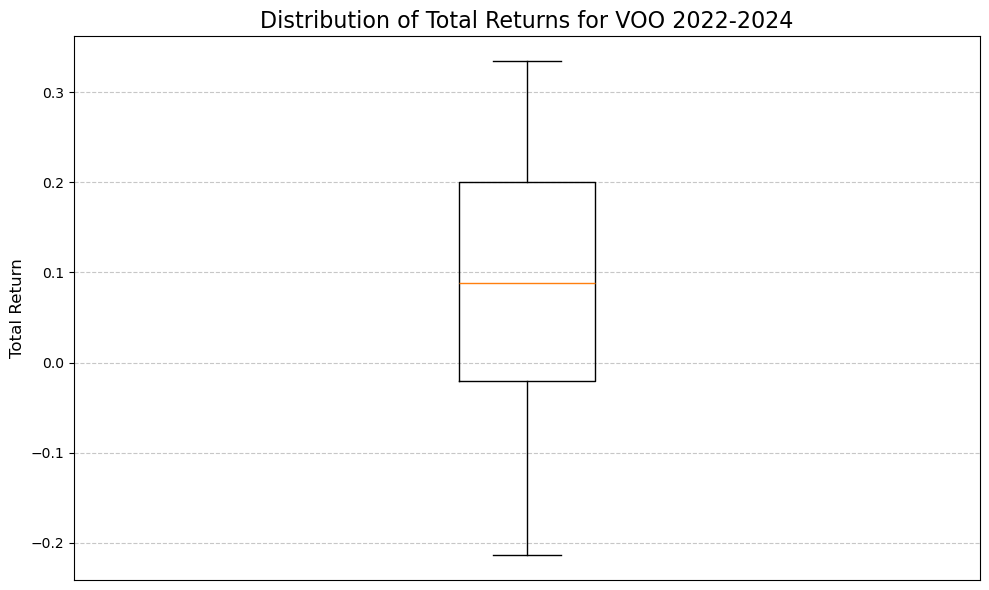

In [34]:
gains=[]

df_to_sample = pd.read_csv('All_Stock_Data_TTM_RS_2022-2024.csv')
df_to_sample['Date']=pd.to_datetime(df_to_sample['Date'])
filter_date=pd.to_datetime('2022-02-01')
df_to_sample=df_to_sample[df_to_sample['Date']>=filter_date]
for _ in range(20):
    df=sample_stocks_by_date(df_to_sample, n_samples=9)
    df=filter_by_date(df,start_24,end_24)
    D, values, dates=spf.invest_symmetric(df,metrics=['No Metric'],print_summary=False)
    #print(D)
    gains.append((D['No Metric'][1]-D['No Metric'][0])/D['No Metric'][0])
    
gains=np.array(gains)
print()
print('**'*15,'Summary Statistics','**'*15)
print('\tAverage Percent Gain: ', gains.mean())
print('\tStandard Deviation of Percent Gains: ', gains.std())
print('\tMaximum Return', gains.max())
print('\tMinimum Return', gains.min())
mean, confidence_interval = calculate_confidence_interval(gains)
print(f"\t99% Confidence Interval: ({confidence_interval[0]:.2f}, {confidence_interval[1]:.2f})")
# Assuming 'gains' is your list of values
plt.figure(figsize=(10, 6))
plt.boxplot(gains)

plt.title("Distribution of Total Returns for VOO 2022-2024", fontsize=16)
plt.ylabel("Total Return", fontsize=12)

# Remove x-axis label as it's not needed for a single boxplot
plt.xticks([])

# Add a grid for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()




****************************** Summary Statistics ******************************
	Average Percent Gain:  0.4354277469422191
	Standard Deviation of Percent Gains:  0.20157351636249798
	Maximum Return 0.8762381140442664
	Minimum Return 0.1190097704105492
	99% Confidence Interval: (0.30, 0.57)


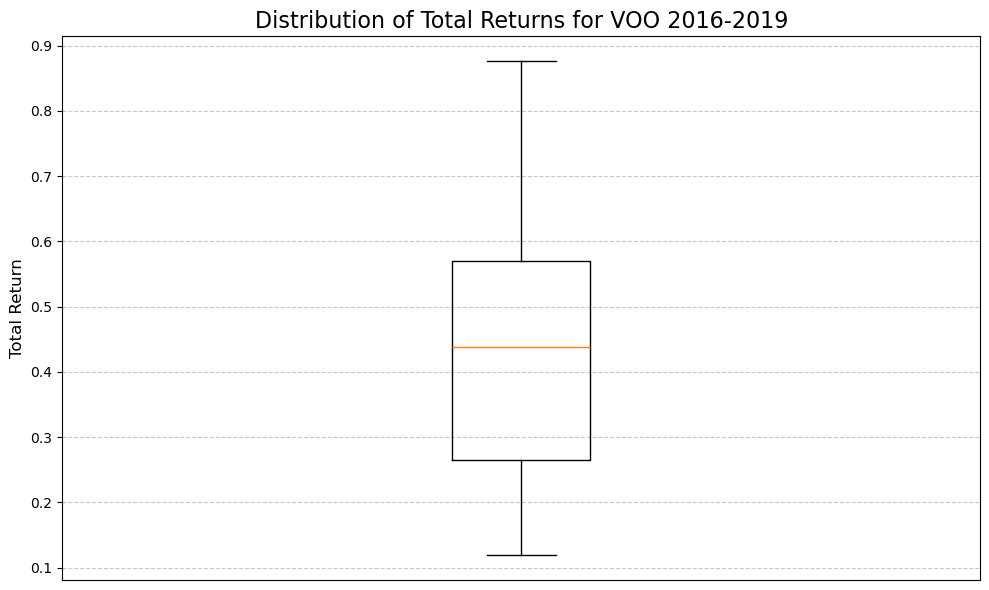

In [35]:
gains_19=[]
df_to_sample_2=pd.read_csv(f'All_Stock_Data_TTM_RS_2016-2019.csv')
for _ in range(20):
    df=sample_stocks_by_date(df_to_sample_2, n_samples=9)
    D, values, dates=spf.invest_symmetric(df,metrics=['No Metric'],print_summary=False)
    
    gains_19.append((D['No Metric'][1]-D['No Metric'][0])/D['No Metric'][0])
    
    
gains_19=np.array(gains_19)
print()
print('**'*15,'Summary Statistics','**'*15)
print('\tAverage Percent Gain: ', gains_19.mean())
print('\tStandard Deviation of Percent Gains: ', gains_19.std())
print('\tMaximum Return', gains_19.max())
print('\tMinimum Return', gains_19.min())
mean, confidence_interval = calculate_confidence_interval(gains_19)
print(f"\t99% Confidence Interval: ({confidence_interval[0]:.2f}, {confidence_interval[1]:.2f})")
# Assuming 'gains' is your list of values
plt.figure(figsize=(10, 6))
plt.boxplot(gains_19)

plt.title("Distribution of Total Returns for VOO 2016-2019", fontsize=16)
plt.ylabel("Total Return", fontsize=12)

# Remove x-axis label as it's not needed for a single boxplot
plt.xticks([])

# Add a grid for better readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
    

**We see much higher gains for the 2016-2019 period, compared to 2022-2024.  There is a lot of variablity in the data.  The gains ranged from 27% to 110% depending on which random stocks were chosen.**

# Strategy Investment simulations

### Metric/Strategy: Slope of the relative strength values
### Hold: 20 Days
### Invest: Everyday
### Period: 2022-2024
### Stock Subset: Largest Stocks Only

In [39]:

test_df=df_one_twenty24.dropna(subset='Percent Gain')
test_df=filter_by_date(test_df,start_24,end_24)
investments=spf.Invest(test_df,['Slope','Corr', 'Product'],accounts=20)
print('Amount Put In')
print('\t',investments.initial_investments)
print()
print('Value of Account')
print('\t',investments.totals)
print()
print('Percent Gains')
print('\t',investments.percent_gains)




Amount Put In
	 {'Slope': 1000, 'Corr': 1000, 'Product': 1000}

Value of Account
	 {'Slope': 1169.9041637454095, 'Corr': 1163.0977286781483, 'Product': 1114.670072735483}

Percent Gains
	 {'Slope': 16.99041637454095, 'Corr': 16.309772867814832, 'Product': 11.467007273548301}


### Strategy/Metric: Slope of relative strength values
### Hold: 1 Day
### Invest: Everyday
### Period: 2022-2024
### Stock Subset: Largest Stocks only

In [41]:
test_df=df_one_one24.dropna(subset='Percent Gain')
test_df=filter_by_date(test_df,start_24,end_24)
investments=spf.Invest(test_df,['Slope','Corr', 'Product'],accounts=1)
print('Amount Put In')
print('\t',investments.initial_investments)
print()
print('Value of Account')
print('\t',investments.totals)
print()
print('Percent Gains')
print('\t',investments.percent_gains)


Amount Put In
	 {'Slope': 1000, 'Corr': 1000, 'Product': 1000}

Value of Account
	 {'Slope': 1765.9477751166287, 'Corr': 1415.0435813367606, 'Product': 1594.2577679054784}

Percent Gains
	 {'Slope': 76.59477751166285, 'Corr': 41.50435813367606, 'Product': 59.425776790547836}


### Strategy/Metric: Slope of relative strength values
### Hold: 20 Day
### Invest: Everyday
### Period: 2016-2019

In [43]:
test_df=df_one_twenty19.dropna(subset='Percent Gain')
test_df=filter_by_date(test_df,start_19,end_19)
investments=spf.Invest(test_df,['Slope','Corr', 'Product'],accounts=20)
print('Amount Put In')
print('\t',investments.initial_investments)
print()
print('Value of Account')
print('\t',investments.totals)
print()
print('Percent Gains')
print('\t',investments.percent_gains)


Amount Put In
	 {'Slope': 1000, 'Corr': 1000, 'Product': 1000}

Value of Account
	 {'Slope': 1411.1591463394188, 'Corr': 376.3101154263608, 'Product': 1437.7715062961208}

Percent Gains
	 {'Slope': 41.11591463394188, 'Corr': -62.36898845736391, 'Product': 43.77715062961209}


### Strategy/Metric: Slope of relative strength values
### Hold: 1 Day
### Invest: Everyday
### Period: 2016-2019
### Stock Subset: Largest Stocks Only

In [45]:
test_df=df_one_one19.dropna(subset='Percent Gain')
test_df=filter_by_date(test_df,start_19,end_19)
investments=spf.Invest(test_df,['Slope','Corr', 'Product'],accounts=1)
print('Amount Put In')
print('\t',investments.initial_investments)
print()
print('Value of Account')
print('\t',investments.totals)
print()
print('Percent Gains')
print('\t',investments.percent_gains)


Amount Put In
	 {'Slope': 1000, 'Corr': 1000, 'Product': 1000}

Value of Account
	 {'Slope': 1785.940920847183, 'Corr': 9.853778315536074e-12, 'Product': 1649.9280215907938}

Percent Gains
	 {'Slope': 78.5940920847183, 'Corr': -99.999999999999, 'Product': 64.99280215907937}


### Strategy/Metric: Slope of percent changes of the relative strength values.
### Hold: 1 Day
### Invest: Everyday
### Period: 2022-2024
### Stock Subset: All Stocks


In [47]:
test_df=df_one_one24_pct.dropna(subset='Percent Gain')
test_df=filter_by_date(test_df,start_24,end_24)
investments=spf.Invest(test_df,['Product_pct_change','Rs_percent_change_slope', 'Rs_percent_change_corr'],accounts=1)
print('Amount Put In')
print('\t',investments.initial_investments)
print()
print('Value of Account')
print('\t',investments.totals)
print()
print('Percent Gains')
print('\t',investments.percent_gains)

Amount Put In
	 {'Product_pct_change': 1000, 'Rs_percent_change_slope': 1000, 'Rs_percent_change_corr': 1000}

Value of Account
	 {'Product_pct_change': 8.195026217732582e-15, 'Rs_percent_change_slope': 1.503674891691856e-15, 'Rs_percent_change_corr': 5.744408839191444e-22}

Percent Gains
	 {'Product_pct_change': -100.0, 'Rs_percent_change_slope': -100.0, 'Rs_percent_change_corr': -100.0}


### Strategy/Metric: Slope of percent changes of the relative strength values.
### Hold: 20 Day
### Invest: Everyday
### Period: 2022-2024
### Stock Subset: All Stocks

In [49]:
test_df=df_one_twenty24_pct.dropna(subset='Percent Gain')
test_df=filter_by_date(test_df,start_24,end_24)
investments=spf.Invest(test_df,['Product_pct_change','Rs_percent_change_slope', 'Rs_percent_change_corr'],accounts=20)
print('Amount Put In')
print('\t',investments.initial_investments)
print()
print('Value of Account')
print('\t',investments.totals)
print()
print('Percent Gains')
print('\t',investments.percent_gains)

Amount Put In
	 {'Product_pct_change': 1000, 'Rs_percent_change_slope': 1000, 'Rs_percent_change_corr': 1000}

Value of Account
	 {'Product_pct_change': 359.1196201569442, 'Rs_percent_change_slope': 402.0722922922623, 'Rs_percent_change_corr': 195.61238720675001}

Percent Gains
	 {'Product_pct_change': -64.08803798430559, 'Rs_percent_change_slope': -59.79277077077377, 'Rs_percent_change_corr': -80.438761279325}


### Slope of the percent change of the relative strength values.
### Hold: 20 Day
### Invest: Everyday
### Period: 2016-2019
### Stock Subset: All Stocks

In [51]:
test_df=df_one_twenty19_pct.dropna(subset='Percent Gain')
test_df=filter_by_date(test_df,start_19,end_19)
investments=spf.Invest(test_df,['Product_pct_change','Rs_percent_change_slope', 'Rs_percent_change_corr'],accounts=20)
print('Amount Put In')
print('\t',investments.initial_investments)
print()
print('Value of Account')
print('\t',investments.totals)
print()
print('Percent Gains')
print('\t',investments.percent_gains)

Amount Put In
	 {'Product_pct_change': 1000, 'Rs_percent_change_slope': 1000, 'Rs_percent_change_corr': 1000}

Value of Account
	 {'Product_pct_change': 1892.2542760343072, 'Rs_percent_change_slope': 1883.9306511778414, 'Rs_percent_change_corr': 1663.7684964447026}

Percent Gains
	 {'Product_pct_change': 89.22542760343072, 'Rs_percent_change_slope': 88.39306511778413, 'Rs_percent_change_corr': 66.37684964447025}


### Slope of the percent change of the relative strength values.
### Hold: 1 Day
### Invest: Everyday
### Period: 2016-2019
### Stock Subset: All Stocks

In [53]:
test_df=df_one_one19_pct.dropna(subset='Percent Gain')
test_df=filter_by_date(test_df,start_19,end_19)
investments=spf.Invest(test_df,['Product_pct_change','Rs_percent_change_slope', 'Rs_percent_change_corr'],accounts=1)
print('Amount Put In')
print('\t',investments.initial_investments)
print()
print('Value of Account')
print('\t',investments.totals)
print()
print('Percent Gains')
print('\t',investments.percent_gains)

Amount Put In
	 {'Product_pct_change': 1000, 'Rs_percent_change_slope': 1000, 'Rs_percent_change_corr': 1000}

Value of Account
	 {'Product_pct_change': 958.6047508101204, 'Rs_percent_change_slope': 925.2171068715626, 'Rs_percent_change_corr': 1210.337683494458}

Percent Gains
	 {'Product_pct_change': -4.139524918987956, 'Rs_percent_change_slope': -7.478289312843743, 'Rs_percent_change_corr': 21.03376834944579}


### Strategy/Metric: Weighted sum of the slope of the cumulative product of the percent changes of the relative strength values and other indicators such as recent raw relative strength values.
### Hold: 1 Day
### Invest: Everyday
### Period: 2022-2024
### Stock Subset: Largest Stocks Only


In [55]:
df_one_one24_pct_plus['End Date']=pd.to_datetime(df_one_one24_pct_plus['End Date'])
df_one_one24_pct_plus=df_one_one24_pct_plus.sort_values(by='End Date')
test_df=df_one_one24_pct_plus.dropna(subset='Percent Gain')
test_df=filter_by_date(test_df,start_24,end_24)
investments=spf.Invest(test_df,['My_Metric'],accounts=1)
print('Amount Put In')
print('\t',investments.initial_investments)
print()
print('Value of Account')
print('\t',investments.totals)
print()
print('Percent Gains')
print('\t',investments.percent_gains)

Amount Put In
	 {'My_Metric': 1000}

Value of Account
	 {'My_Metric': 1937.4498364725725}

Percent Gains
	 {'My_Metric': 93.74498364725724}


### Strategy/Metric: Weighted sum of the slope of the cumulative product of the percent changes of the relative strength values and other indicators such as recent raw relative strength values.
### Hold: 1 Day
### Invest: Everyday
### Period: 2016-2019
### Stock Subset: Largest Stocks Only

In [87]:
df_one_one19_pct_plus['Metric']='My_Metric'
df_one_one19_pct_plus['End Date']=pd.to_datetime(df_one_one19_pct_plus['End Date'])
df_one_one19_pct_plus=df_one_one19_pct_plus.sort_values(by='End Date')
test_df=df_one_one19_pct_plus.dropna(subset='Percent Gain')
test_df=filter_by_date(test_df,start_19,end_19)
investments=spf.Invest(test_df,metrics=['My_Metric'],accounts=1)
print('Amount Put In')
print('\t',investments.initial_investments)
print()
print('Value of Account')
print('\t',investments.totals)
print()
print('Percent Gains')
print('\t',investments.percent_gains)

Amount Put In
	 {'My_Metric': 1000}

Value of Account
	 {'My_Metric': 2245.4894695097632}

Percent Gains
	 {'My_Metric': 124.54894695097633}


### Strategy/Metric: Weighted sum of the slope of the cumulative product of the percent changes of the relative strength values and other indicators such as recent raw relative strength values.
### Hold: 1 Day
### Invest: Everyday
### Period: 2022-2024
### Stock Subset: All Stocks

In [89]:
df_one_one24_pct_plus_more['End Date']=pd.to_datetime(df_one_one24_pct_plus_more['End Date'])
df_one_one24_pct_plus_more=df_one_one24_pct_plus_more.sort_values(by='End Date')
test_df=df_one_one24_pct_plus_more.dropna(subset='Percent Gain')
test_df=filter_by_date(test_df,start_24,end_24)
investments=spf.Invest(test_df,['My_Metric'],accounts=1)
print('Amount Put In')
print('\t',investments.initial_investments)
print()
print('Value of Account')
print('\t',investments.totals)
print()
print('Percent Gains')
print('\t',investments.percent_gains)

Amount Put In
	 {'My_Metric': 1000}

Value of Account
	 {'My_Metric': 2281.6766592445115}

Percent Gains
	 {'My_Metric': 128.16766592445114}


### Strategy/Metric: Predicted probability of positive gains from xgBoost model.
### Hold: 1 Day
### Invest: Everyday
### Period: 2022-2024

In [91]:
df_one_one_xg['End Date']=pd.to_datetime(df_one_one_xg['End Date'])
df_one_one_xg=df_one_one_xg.sort_values(by='End Date')
test_df=df_one_one_xg.dropna(subset='Percent Gain')
test_df=filter_by_date(test_df,start_24,end_24)
investments=spf.Invest(test_df,metrics=['Predict_From_Model'],accounts=1)
print('Amount Put In')
print('\t',investments.initial_investments)
print()
print('Value of Account')
print('\t',investments.totals)
print()
print('Percent Gains')
print('\t',investments.percent_gains)

Amount Put In
	 {'Predict_From_Model': 1000}

Value of Account
	 {'Predict_From_Model': 1.3108854166911275e-08}

Percent Gains
	 {'Predict_From_Model': -99.9999999986891}


### Strategy/Metric: Predicted probably of positive gains from xgBoost model.  The model was fit using a rolling fit
### Hold: 1 Day
### Invest: Everyday
### Period: 2016-2019

In [13]:
df_one_twenty_xg_rolling19['End Date']=pd.to_datetime(df_one_twenty_xg_rolling19['End Date'])
df_one_twenty_xg_rolling19=df_one_twenty_xg_rolling19.sort_values(by='End Date')
test_df=df_one_twenty_xg_rolling19.dropna(subset='Percent Gain')
test_df=filter_by_date(test_df,start_19,end_19)
investments=spf.Invest(test_df,metrics=['Predict_From_Model'],accounts=20)
print('Amount Put In')
print('\t',investments.initial_investments)
print()
print('Value of Account')
print('\t',investments.totals)
print()
print('Percent Gains')
print('\t',investments.percent_gains)

Amount Put In
	 {'Predict_From_Model': 1000}

Value of Account
	 {'Predict_From_Model': 4028.0863770171777}

Percent Gains
	 {'Predict_From_Model': 302.80863770171777}


### Strategy/Metric: Predicted probability of positive gains from xgBoost model.  Rolling fit used.
### Hold: 1 Day
### Invest: Everyday
### Period: 2022-2024
### Stock Subset: All stocks

In [11]:
df_one_twenty_xg_rolling24['End Date']=pd.to_datetime(df_one_twenty_xg_rolling24['End Date'])
df_one_twenty_xg_rolling24=df_one_twenty_xg_rolling24.sort_values(by='End Date')
test_df=df_one_twenty_xg_rolling24.dropna(subset='Percent Gain')
test_df=filter_by_date(test_df,start_24,end_24)
investments=spf.Invest(test_df,metrics=['Predict_From_Model'],accounts=20)
print('Amount Put In')
print('\t',investments.initial_investments)
print()
print('Value of Account')
print('\t',investments.totals)
print()
print('Percent Gains')
print('\t',investments.percent_gains)

Amount Put In
	 {'Predict_From_Model': 1000}

Value of Account
	 {'Predict_From_Model': 89.7182056569563}

Percent Gains
	 {'Predict_From_Model': -91.02817943430436}


### Strategy/Metric: Weighted sum of the slope of the cumulative product of the percent changes of the relative strength values and other indicators such as recent raw relative strength values.
### Hold: 1 Day
### Invest: Everyday
### Period: 2016-2019
### Stock Subset: All stocks

In [124]:
df_one_one19_pct_plus_more['End Date']=pd.to_datetime(df_one_one19_pct_plus_more['End Date'])
df_one_one19_pct_plus_more=df_one_one19_pct_plus_more.sort_values(by='End Date')
test_df=df_one_one19_pct_plus_more.dropna(subset='Percent Gain')
test_df=filter_by_date(test_df,start_19,end_19)
investments=spf.Invest(test_df,['My_Metric'],accounts=1)
print('Amount Put In')
print('\t',investments.initial_investments)
print()
print('Value of Account')
print('\t',investments.totals)
print()
print('Percent Gains')
print('\t',investments.percent_gains)

Amount Put In
	 {'My_Metric': 1000}

Value of Account
	 {'My_Metric': 2245.4894695097614}

Percent Gains
	 {'My_Metric': 124.54894695097614}


### Strategy/Metric: Predicted Probability from xgBoost model
### Hold: 4 Day
### Invest: Everyday
### Period: 2022-2024
### Stock Subset: All stocks

In [126]:
df_one_four_xg['End Date']=pd.to_datetime(df_one_four_xg['End Date'])
df_one_four_xg=df_one_four_xg.sort_values(by='End Date')
test_df=df_one_four_xg.dropna(subset='Percent Gain')
test_df=filter_by_date(test_df,start_24,end_24)
investments=spf.Invest(test_df,metrics=['Predict_From_Model'],accounts=4)
print('Amount Put In')
print('\t',investments.initial_investments)
print()
print('Value of Account')
print('\t',investments.totals)
print()
print('Percent Gains')
print('\t',investments.percent_gains)

Amount Put In
	 {'Predict_From_Model': 1000}

Value of Account
	 {'Predict_From_Model': 13.1638958492488}

Percent Gains
	 {'Predict_From_Model': -98.68361041507512}


### Hold: 7 Day
### Invest: Everyday
### Period: 2022-2024
### Strategy: XgBoost Model predict_proba

In [128]:
df_one_seven_xg19_ttm['End Date']=pd.to_datetime(df_one_seven_xg19_ttm['End Date'])
df_one_seven_xg19_ttm=df_one_seven_xg19_ttm.sort_values(by='End Date')
test_df=df_one_seven_xg19_ttm.dropna(subset='Percent Gain')
test_df=filter_by_date(test_df,start_19,end_19)
investments=spf.Invest(test_df,['Predict_From_Model'],accounts=7)
print('Amount Put In')
print('\t',investments.initial_investments)
print()
print('Value of Account')
print('\t',investments.totals)
print()
print('Percent Gains')
print('\t',investments.percent_gains)

Amount Put In
	 {'Predict_From_Model': 1000}

Value of Account
	 {'Predict_From_Model': 1039.1334720647833}

Percent Gains
	 {'Predict_From_Model': 3.913347206478329}


### Strategy/Metric: Slope of the Cumulative product of the percent changes of the relative strength values.
### Hold: 1 Day
### Invest: Everyday
### Period: 2016-2019
### Stock Subset: All stocks

In [130]:
df_one_one19_cum_prod=df_one_one19_cum_prod.sort_values(by='End Date')
test_df=df_one_one19_cum_prod.dropna(subset=['Percent Gain'])
test_df=filter_by_date(test_df,start_19,end_19)

D, values, dates=spf.invest_symmetric(test_df,metrics=['Rs_slope'])


Summary

Strategy                 Amount Invested          Value after Period       
Rs_slope                 1000                     1895.298368402765        


### Strategy/Metric: Correlation coefficient of the cum prod of the pct changes of the relative strength values with time.
### Hold: 1 Day
### Invest: Everyday
### Period: 2016-2019
### Stock Subset: All stocks

In [132]:

df_one_one19_corr=df_one_one19_corr.sort_values(by='End Date')
test_df=df_one_one19_corr.dropna(subset=['Percent Gain'])
test_df=filter_by_date(test_df,start_19,end_19)

D, values, dates=spf.invest_symmetric(test_df,metrics=['Correlation'])

Summary

Strategy                 Amount Invested          Value after Period       
Correlation              1000                     1544.7130970268342       


In [9]:
new_var_name='df_one_twenty24_xg_rolling_multi'
strat='predict_from_multiclass_model'
df_one_twenty24_xg_rolling_multi['End Date']=pd.to_datetime(df_one_twenty24_xg_rolling_multi['End Date'])
df_one_twenty24_xg_rolling_multi=df_one_twenty24_xg_rolling_multi.sort_values(by='End Date')
test_df=df_one_twenty24_xg_rolling_multi.dropna(subset='Percent Gain')
test_df=filter_by_date(test_df,start_24,end_24)
investments=spf.Invest(test_df,['predict_from_multiclass_model'],accounts=20)
print('Amount Put In')
print('\t',investments.initial_investments)
print()
print('Value of Account')
print('\t',investments.totals)
print()
print('Percent Gains')
print('\t',investments.percent_gains)

Amount Put In
	 {'predict_from_multiclass_model': 1000}

Value of Account
	 {'predict_from_multiclass_model': 6.54596063447605}

Percent Gains
	 {'predict_from_multiclass_model': -99.34540393655239}


### Strategy/Metric: Product of the slope of the cumulative product and the correlation coefficient of the relative strength values with time.
### Hold: 1 Day
### Invest: Everyday
### Period: 2016-2019
### Stock Subset: All stocks

In [134]:
df_one_one19_product=df_one_one19_product.sort_values(by='End Date')
test_df=df_one_one19_product.dropna(subset=['Percent Gain'])
test_df=filter_by_date(test_df,start_19,end_19)

D, values, dates=spf.invest_symmetric(test_df,metrics=['Product'])

Summary

Strategy                 Amount Invested          Value after Period       
Product                  1000                     2521.450449351457        


### Strategy/Metric: Product of the slope of the cumulative product and the correlation coefficient of the relative strength values with time.
### Hold: 1 Day
### Invest: Everyday
### Period: 2022-2024
### Stock Subset: All stocks

In [136]:
df_one_one24_product['End Date']=pd.to_datetime(df_one_one24_product['End Date'])
df_one_one24_product=df_one_one24_product[df_one_one24_product['End Date']>=pd.to_datetime('2022-02-01')]
df_one_one24_product=df_one_one24_product.sort_values(by='End Date')
test_df=df_one_one24_product.dropna(subset=['Percent Gain'])
test_df=filter_by_date(test_df,start_24,end_24)

D, values, dates=spf.invest_symmetric(test_df,metrics=['Product'])

Summary

Strategy                 Amount Invested          Value after Period       
Product                  1000                     2579.2058011722756       


# Performance by Average Percent gain

In [138]:
print_avg_gains_by_year_and_holding(files_df)

*************** Year: 2016-2019, Holding Period: 1 ***************

Strategy: Percent Change Plus: Larger Stocks
	Average Percent Gain: Percent Change Plus
		 My_Metric :  0.09201545164820281

Strategy: Original Slope: Larger Stocks
	Average Percent Gain: Original Slope
		 Corr :  0.06130410816317279

		 Product :  0.056085954820229156

		 Slope :  0.0640087010648349

Strategy: Percent Change Plus: Larger Stocks
	Average Percent Gain: Percent Change Plus
		 My_Metric :  0.09201545164820282

Strategy: Percent Change: All Stocks
	Average Percent Gain: Percent Change
		 Product_pct_change :  0.0629691981993655

		 Rs_percent_change_corr :  0.048796111337806855

		 Rs_percent_change_slope :  0.07472628038468414

Strategy: Product: All Stocks
	Average Percent Gain: Product
		 Product :  0.06848350179567735

Strategy: Correlation: All Stocks
	Average Percent Gain: Correlation
		 Correlation :  0.06688441335678796

Strategy: Cum RS_Slope: All Stocks
	Average Percent Gain: Cum RS_Slope
		 Rs_s

*&emsp;The* **Product** *(of the slope of the cumprod relative strength values and spearman correlation coefficient) strategy consistently had a higher average percent gain for a 1 day hold in both periods.  There were other instances of higher average percent gains, but the product was high in both periods.*

In [140]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_cumulative_performance(test_df, benchmark_df, test_label='Test Strategy', benchmark_label='Benchmark'):
    # Ensure 'End Date' is in datetime format
    test_df['End Date'] = pd.to_datetime(test_df['End Date'])
    benchmark_df['End Date'] = pd.to_datetime(benchmark_df['End Date'])

    # Sort dataframes by date
    test_df = test_df.sort_values('End Date')
    benchmark_df = benchmark_df.sort_values('End Date')

    # Calculate cumulative returns
    test_cumulative = (1 + test_df['Percent Gain']).cumprod() - 1
    benchmark_cumulative = (1 + benchmark_df['Percent Gain']).cumprod() - 1

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot cumulative returns
    ax.plot(test_df['End Date'], test_cumulative, label=test_label)
    ax.plot(benchmark_df['End Date'], benchmark_cumulative, label=benchmark_label)

    # Set labels and title
    ax.set_xlabel('Date')
    ax.set_ylabel('Cumulative Return')
    ax.set_title('Cumulative Performance Comparison')

    # Add legend
    ax.legend()

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Add grid
    ax.grid(True, linestyle='--', alpha=0.7)

    # Tight layout to prevent clipping of labels
    plt.tight_layout()

    # Show the plot
    plt.show()

    # Print final cumulative returns
    print(f"{test_label} Final Cumulative Return: {test_cumulative.iloc[-1]:.2%}")
    print(f"{benchmark_label} Final Cumulative Return: {benchmark_cumulative.iloc[-1]:.2%}")


def plot_total_performance(test_df, benchmark_df, test_label='Test Strategy', benchmark_label='Benchmark'):
    # Ensure 'End Date' is in datetime format
    test_df['End Date'] = pd.to_datetime(test_df['End Date'])
    benchmark_df['End Date'] = pd.to_datetime(benchmark_df['End Date'])

    # Sort dataframes by date
    test_df = test_df.sort_values('End Date')
    benchmark_df = benchmark_df.sort_values('End Date')

    # Group by date and calculate average percent gain
    test_daily = test_df.groupby('End Date')['Percent Gain'].mean().reset_index()
    benchmark_daily = benchmark_df.groupby('End Date')['Percent Gain'].mean().reset_index()

    # Align dates
    all_dates = pd.date_range(start=min(test_daily['End Date'].min(), benchmark_daily['End Date'].min()),
                              end=max(test_daily['End Date'].max(), benchmark_daily['End Date'].max()))
    
    test_daily = test_daily.set_index('End Date').reindex(all_dates).fillna(0).reset_index()
    benchmark_daily = benchmark_daily.set_index('End Date').reindex(all_dates).fillna(0).reset_index()

    # Calculate cumulative returns using geometric mean
    test_cumulative = (1 + test_daily['Percent Gain']).cumprod() - 1
    benchmark_cumulative = (1 + benchmark_daily['Percent Gain']).cumprod() - 1

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot cumulative returns
    ax.plot(test_daily['index'], test_cumulative, label=test_label)
    ax.plot(benchmark_daily['index'], benchmark_cumulative, label=benchmark_label)

    # Set labels and title
    ax.set_xlabel('Date')
    ax.set_ylabel('Cumulative Return')
    ax.set_title('Cumulative Performance Comparison')

    # Add legend
    ax.legend()

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Add grid
    ax.grid(True, linestyle='--', alpha=0.7)

    # Tight layout to prevent clipping of labels
    plt.tight_layout()

    # Show the plot
    plt.show()

    # Print final cumulative returns
    print(f"{test_label} Final Cumulative Return: {test_cumulative.iloc[-1]:.2%}")
    print(f"{benchmark_label} Final Cumulative Return: {benchmark_cumulative.iloc[-1]:.2%}")

    # Calculate and print CAGR
    days = (test_daily['index'].iloc[-1] - test_daily['index'].iloc[0]).days
    test_cagr = (1 + test_cumulative.iloc[-1]) ** (365.25 / days) - 1
    benchmark_cagr = (1 + benchmark_cumulative.iloc[-1]) ** (365.25 / days) - 1
    
    print(f"{test_label} CAGR: {test_cagr:.2%}")
    print(f"{benchmark_label} CAGR: {benchmark_cagr:.2%}")


# Cumulative Returns Graphs.  
**The cumulative returns give an idea of how the strategy will perform relative to the market.  Some shortcomings fo this include the fact that it assumes that all stocks are invested in in an equal amount.  However, the strategy invests in the stocks according to the rank of the metric.  (higher Slope*Corr means more money invested) Still these graphs give us an idea of how the strategy performs compared to the overall market (specifically the voo).**

#### Weighted Metric (My_Metric) vs. Market

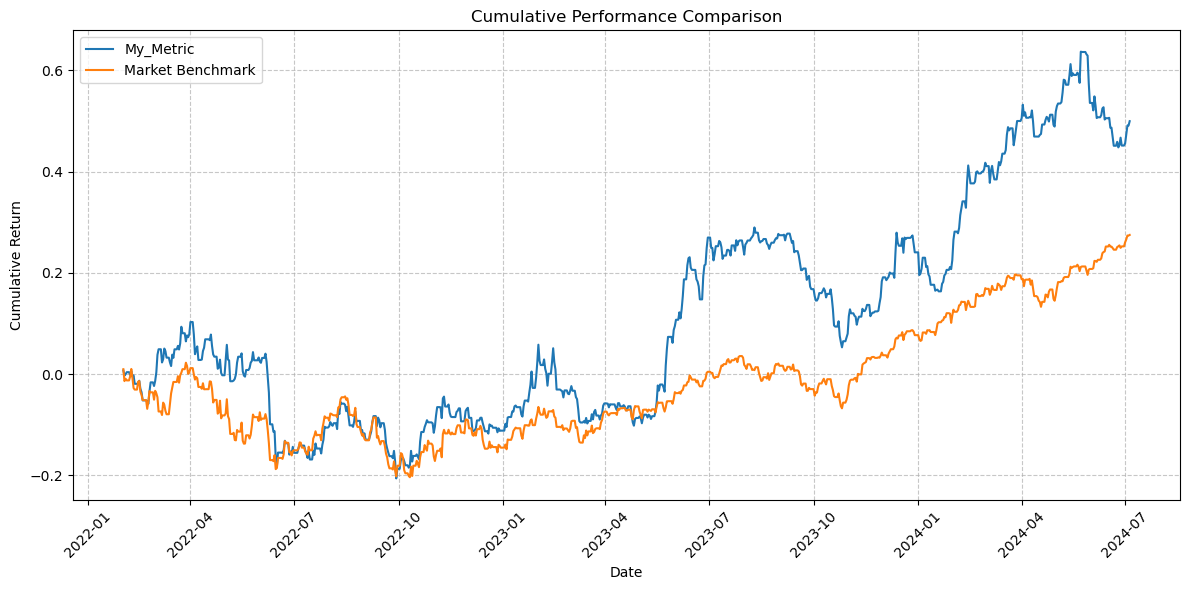

My_Metric Final Cumulative Return: 49.95%
Market Benchmark Final Cumulative Return: 27.48%
My_Metric CAGR: 18.20%
Market Benchmark CAGR: 10.54%


In [143]:
df_one_one24_pct_plus_more['End Date']=pd.to_datetime(df_one_one24_pct_plus_more['End Date'])
df_one_one24_pct_plus_more=df_one_one24_pct_plus_more.sort_values(by='End Date')
test_df=df_one_one24_pct_plus_more.dropna(subset='Percent Gain')
test_df=filter_by_date(test_df,start_24,end_24)
plot_total_performance(test_df, df_voo_1_24, 'My_Metric', 'Market Benchmark')

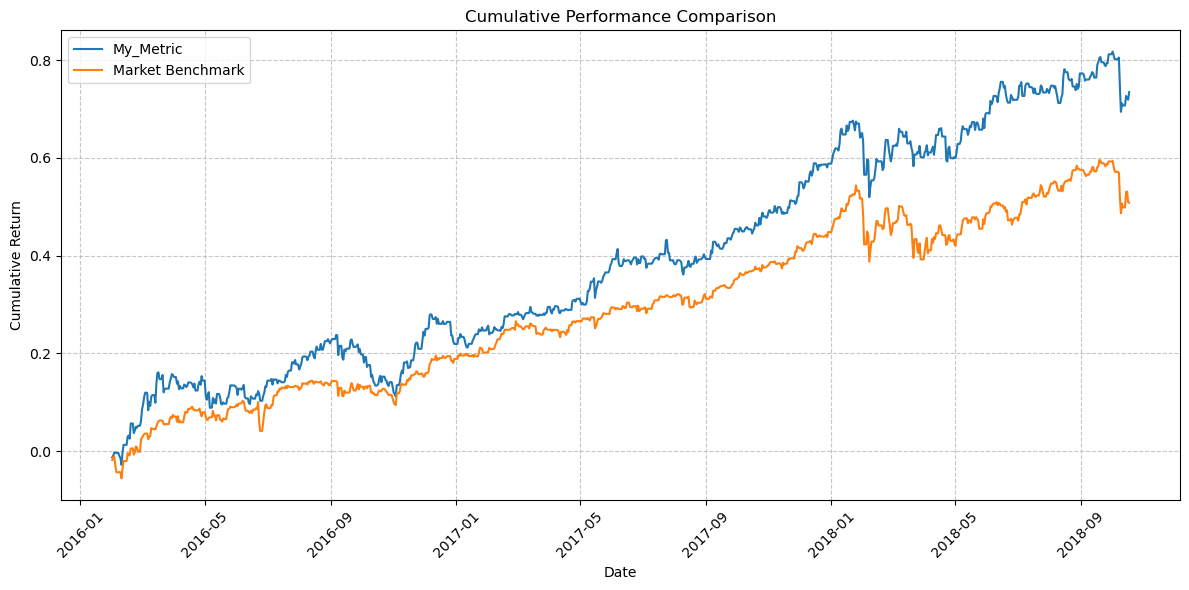

My_Metric Final Cumulative Return: 73.49%
Market Benchmark Final Cumulative Return: 50.85%
My_Metric CAGR: 22.54%
Market Benchmark CAGR: 16.38%


In [161]:
df_one_one19_pct_plus['Metric']='My_Metric'
df_one_one19_pct_plus['End Date']=pd.to_datetime(df_one_one19_pct_plus['End Date'])
df_one_one19_pct_plus=df_one_one19_pct_plus.sort_values(by='End Date')
test_df=df_one_one19_pct_plus.dropna(subset='Percent Gain')
df_voo_1_19['End Date']=pd.to_datetime(df_voo_1_19['End Date'])
test_df=filter_by_date(test_df,start_19,end_19)
plot_total_performance(test_df, df_voo_1_19, 'My_Metric', 'Market Benchmark')

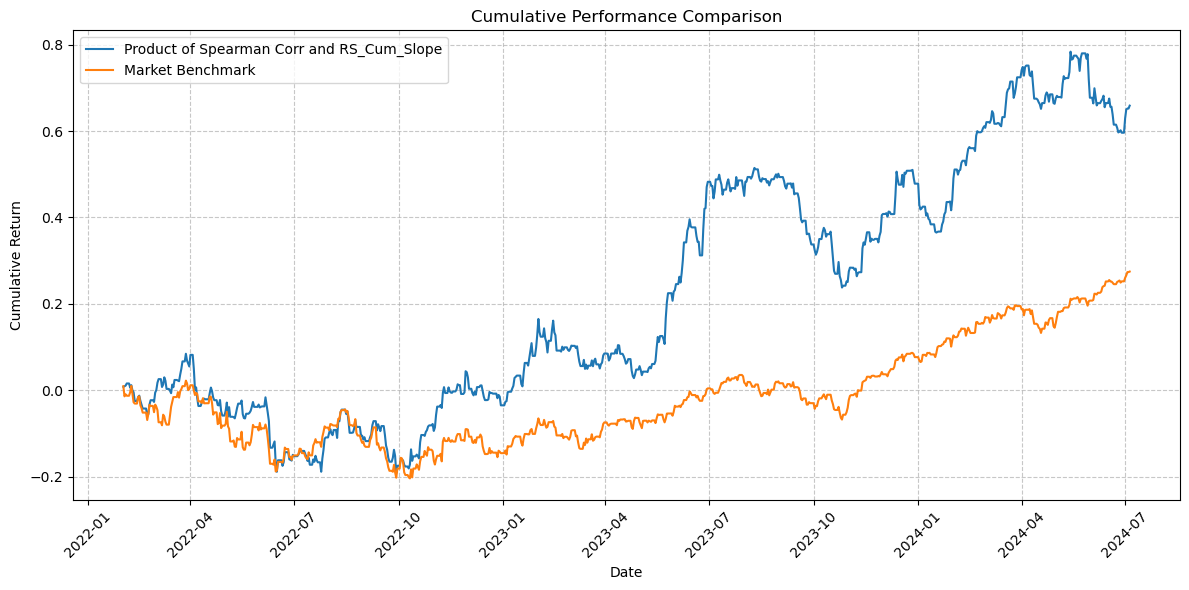

Product of Spearman Corr and RS_Cum_Slope Final Cumulative Return: 65.87%
Market Benchmark Final Cumulative Return: 27.48%
Product of Spearman Corr and RS_Cum_Slope CAGR: 23.23%
Market Benchmark CAGR: 10.54%


In [163]:
df_one_one24_product['End Date']=pd.to_datetime(df_one_one24_product['End Date'])
df_one_one24_product=df_one_one24_product[df_one_one24_product['End Date']>=pd.to_datetime('2022-02-01')]
df_one_one24_product=df_one_one24_product.sort_values(by='End Date')
test_df=df_one_one24_product.dropna(subset=['Percent Gain'])
test_df=filter_by_date(test_df,start_24,end_24)
df_voo_1_24['End Date']=pd.to_datetime(df_voo_1_24['End Date'])
df_voo_1_24=filter_by_date(df_voo_1_24,start_24,end_24)
df_voo_1_24.dropna(subset=['Percent Gain'],inplace=True)
plot_total_performance(test_df, df_voo_1_24, 'Product of Spearman Corr and RS_Cum_Slope', 'Market Benchmark')


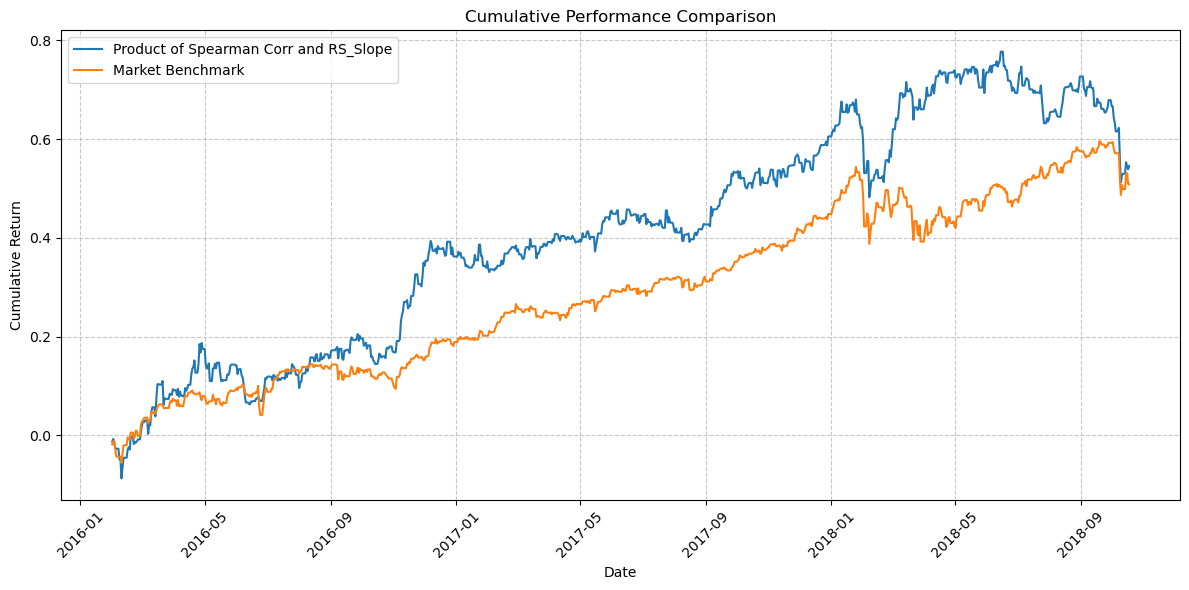

Product of Spearman Corr and RS_Slope Final Cumulative Return: 54.58%
Market Benchmark Final Cumulative Return: 50.85%
Product of Spearman Corr and RS_Slope CAGR: 17.43%
Market Benchmark CAGR: 16.38%


In [164]:
df_one_one19_product=df_one_one19_product.sort_values(by='End Date')
test_df_19=df_one_one19_product.dropna(subset=['Percent Gain'])
df_one_one19_product['End Date']=pd.to_datetime(df_one_one19_product['End Date'])
test_df_19=filter_by_date(test_df_19,start_19,end_19)
df_voo_1_19['End Date']=pd.to_datetime(df_voo_1_19['End Date'])
df_voo_1_19=filter_by_date(df_voo_1_19,start_19,end_19)

plot_total_performance(test_df_19, df_voo_1_19[df_voo_1_19['End Date']<=test_df_19['End Date'].unique()[-1]], 'Product of Spearman Corr and RS_Slope', 'Market Benchmark')

# Predicted Model Probability Strategy

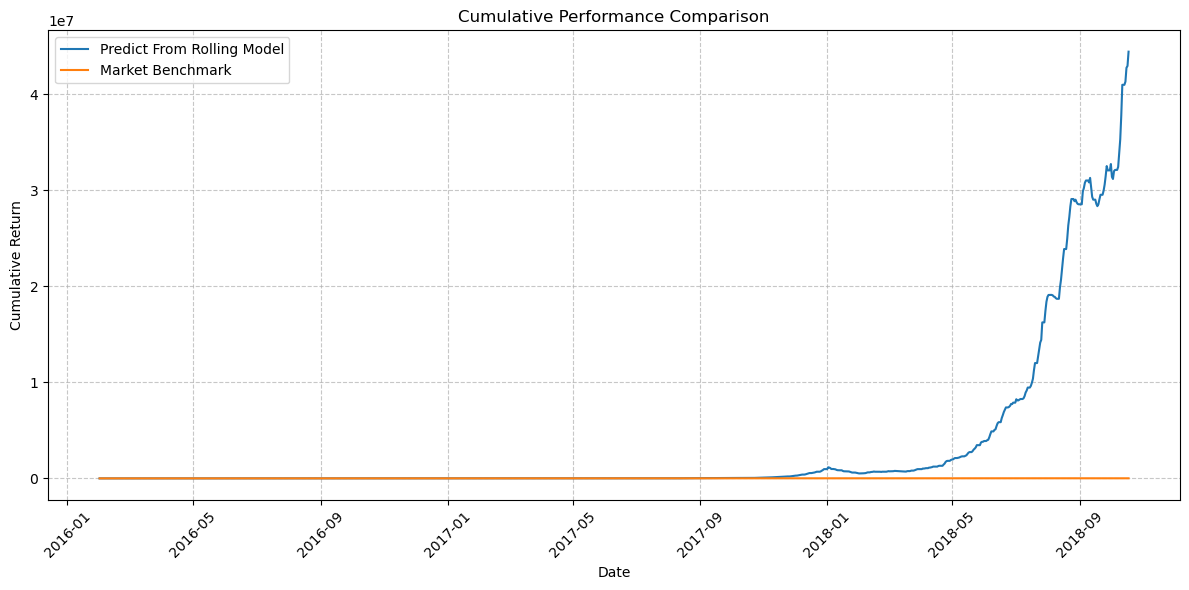

Predict From Rolling Model Final Cumulative Return: 4445005979.71%
Market Benchmark Final Cumulative Return: 941609.51%
Predict From Rolling Model CAGR: 66213.41%
Market Benchmark CAGR: 2825.06%


In [166]:
df_one_twenty_xg_rolling19['End Date']=pd.to_datetime(df_one_twenty_xg_rolling19['End Date'])
df_one_twenty_xg_rolling19=df_one_twenty_xg_rolling19.sort_values(by='End Date')
test_df=df_one_twenty_xg_rolling19.dropna(subset='Percent Gain')
test_df=filter_by_date(test_df,start_19,end_19)
plot_total_performance(test_df, df_voo_20_19[df_voo_20_19['End Date']<=test_df_19['End Date'].unique()[-1]], 'Predict From Rolling Model', 'Market Benchmark')

# Correlation between metric rank and gain rank.
### &emsp;All the investment strategies allot funds according to the metrics rank.  Higher ranked stocks/etfs will recieve more funding for investment.  This strategy is only valid if there is a connection between the metric rank and the actual observered percent change. The graphs below are an accurate representation of how the portfolio will grow if the strategy is followed.  We can see that they depict a larger gap between the market than the cumulative returns graphs shown above.  The strategy of investing in stocks in an amount proportional to the stocks metric rank may account for this.

### Plots For the Product Strategy

Period: 2022-2024
Summary

Strategy                 Amount Invested          Value after Period       
Product                  1000                     2579.205801172276        
Summary

Strategy                 Amount Invested          Value after Period       
VOO                      1000                     1274.775103727832        


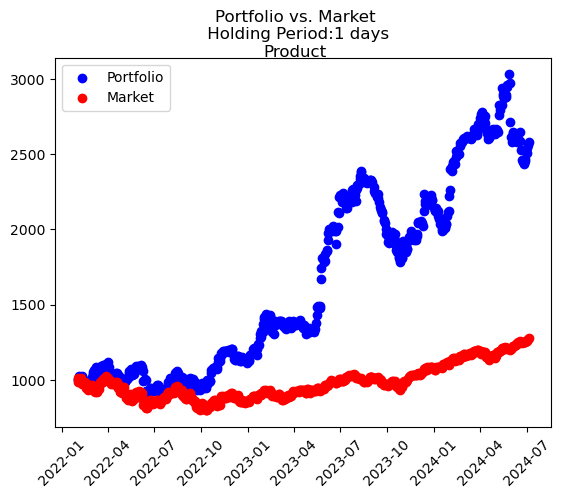

In [169]:
print('Period: 2022-2024')
df_one_one24_product=filter_by_date(df_one_one24_product,start_24,end_24)
spf.plot_vs_market(df_one_one24_product,strategy='Product',holding_period=1,start_date=start_24,end_date=end_24,ignore_action=True)

Period: 2016-2019
Summary

Strategy                 Amount Invested          Value after Period       
Product                  1000                     2521.4504493514587       
Summary

Strategy                 Amount Invested          Value after Period       
VOO                      1000                     1508.4862836388597       


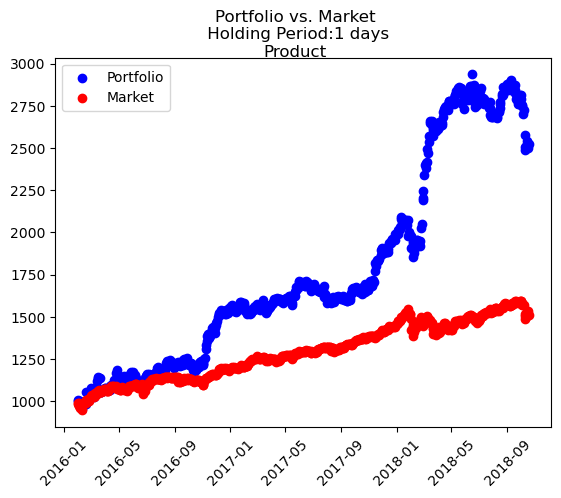

In [170]:
print('Period: 2016-2019')
df_one_one19_product=filter_by_date(df_one_one19_product,start_19,end_19)
spf.plot_vs_market(df_one_one19_product,strategy='Product',holding_period=1,start_date=start_19,end_date=end_19,ignore_action=True)

## Plots for My_Metric Strategy

Period: 2022-2024
Summary

Strategy                 Amount Invested          Value after Period       
My_Metric                1000                     2281.6766592444346       
Summary

Strategy                 Amount Invested          Value after Period       
VOO                      1000                     1274.775103727832        


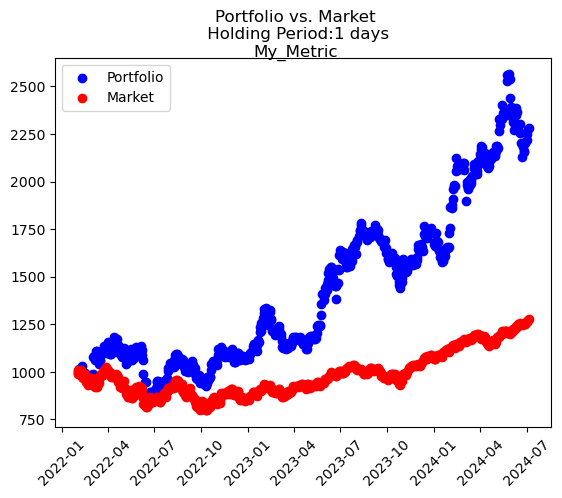

In [172]:
print('Period: 2022-2024')
df_one_one24_pct_plus_more=filter_by_date(df_one_one24_pct_plus_more,start_24,end_24)
spf.plot_vs_market(df_one_one24_pct_plus_more,strategy='My_Metric',holding_period=1,start_date=start_24,end_date=end_24,ignore_action=True)

Period: 2016-2019
Summary

Strategy                 Amount Invested          Value after Period       
My_Metric                1000                     2245.4894695096873       
Summary

Strategy                 Amount Invested          Value after Period       
VOO                      1000                     1508.4862836388597       


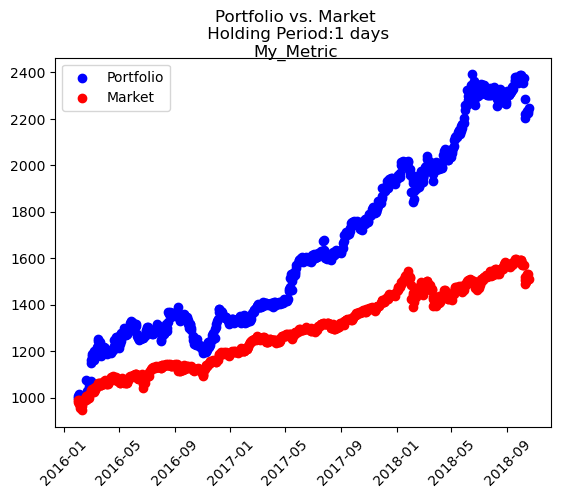

In [173]:
print('Period: 2016-2019')
df_one_one19_pct_plus_more=filter_by_date(df_one_one19_pct_plus_more,start_19,end_19)
spf.plot_vs_market(df_one_one19_pct_plus_more,strategy='My_Metric',holding_period=1,start_date=start_19,end_date=end_19,ignore_action=True)

### Spearman Correlation Coefficients Between the Metric Rank and The Actual Gain rank Product 

#### (Rs_Slope*RS_corr)

In [175]:
spf.get_correlation(df_one_one19_product)
print()
spf.get_correlation(df_one_one24_product)

Average Spearman Correlation Coefficients:
Metric
Product    0.026191
Name: Spearman Correlation, dtype: float64

Summary of Spearman Correlations:
Metric     Product
count   686.000000
mean      0.026191
std       0.438107
min      -0.966667
25%      -0.333333
50%       0.033333
75%       0.366667
max       0.966667

Average Spearman Correlation Coefficients:
Metric
Product    0.030089
Name: Spearman Correlation, dtype: float64

Summary of Spearman Correlations:
Metric     Product
count   609.000000
mean      0.030089
std       0.462670
min      -0.942857
25%      -0.333333
50%       0.028571
75%       0.400000
max       1.000000


### My_Metric

In [177]:
spf.get_correlation(df_one_one19_pct_plus_more)
spf.get_correlation(df_one_one24_pct_plus_more)

Average Spearman Correlation Coefficients:
Metric
My_Metric    0.006889
Name: Spearman Correlation, dtype: float64

Summary of Spearman Correlations:
Metric   My_Metric
count   686.000000
mean      0.006889
std       0.439799
min      -0.950000
25%      -0.333333
50%       0.033333
75%       0.350000
max       0.983333
Average Spearman Correlation Coefficients:
Metric
My_Metric    0.040636
Name: Spearman Correlation, dtype: float64

Summary of Spearman Correlations:
Metric   My_Metric
count   609.000000
mean      0.040636
std       0.441018
min      -0.933333
25%      -0.300000
50%       0.033333
75%       0.383333
max       0.983333


**We see that there is a slight positive correlation between the metric rank and the gain rank for the product strategy.  The spearman correlation coefficient is around 0.025 for both periods.  This seems like a negligible coefficient, but this may be enough to provide a small edge over a strategy that invested in all stocks equally.**

# Filter out predicted 'non-invest days' from model predictions.
**The model used is a model designed to predict bad invest days/periods in the short term.  Recommendations for invest or not invest for each day/etf are stored in the Action_Data csvs.**

In [180]:
df_action_24=pd.read_csv('Action_Data_1_2022-2024.csv')
df_action_19=pd.read_csv('Action_Data_1_2016-2019.csv')

df_one_one19_product['End Date']=pd.to_datetime(df_one_one19_product['End Date']).dt.date
df_one_one24_product['End Date']=pd.to_datetime(df_one_one24_product['End Date']).dt.date
df_action_24['Date']=pd.to_datetime(df_action_24['Date']).dt.date
df_action_19['Date']=pd.to_datetime(df_action_19['Date']).dt.date

ticker_cols=[col for col in df_action_19.columns if 'Ticker' in col]
df_one_one19_product['Action']=df_one_one19_product.apply(lambda x: spf.get_action4(x['End Date'],x['Industry'],df_action_19,ticker_cols,action_column='Predicted_Action2'),axis=1)
ticker_cols=[col for col in df_action_24.columns if 'Ticker' in col]
df_one_one24_product['Action']=df_one_one24_product.apply(lambda x: spf.get_action4(x['End Date'],x['Industry'],df_action_24,ticker_cols,action_column='Predicted_Action2'),axis=1)
                                

In [181]:
df_one_one24_product['End Date']=pd.to_datetime(df_one_one24_product['End Date'])
df_one_one24_product=df_one_one24_product[df_one_one24_product['End Date']>=pd.to_datetime('2022-02-01')]
df_one_one24_product=df_one_one24_product.sort_values(by='End Date')
test_df=df_one_one24_product.dropna(subset=['Percent Gain'])
test_df=filter_by_date(test_df,start_24,end_24)

D, values, dates=spf.invest_symmetric(test_df,metrics=['Product'],ignore_action=False)

Summary

Strategy                 Amount Invested          Value after Period       
Product                  1000                     2472.0792354185687       


In [182]:
df_one_one19_product=df_one_one19_product.sort_values(by='End Date')
test_df=df_one_one19_product.dropna(subset=['Percent Gain'])
test_df['End Date']=pd.to_datetime(test_df['End Date'])
test_df=filter_by_date(test_df,start_19,end_19)
D, values, dates=spf.invest_symmetric(test_df,metrics=['Product'],ignore_action=False)

Summary

Strategy                 Amount Invested          Value after Period       
Product                  1000                     2370.7954489186086       


### The models did not improve the performance in these two cases.

In [184]:
non_invest=df_one_one24_product[df_one_one24_product['Action']==0]
print('Average Percent Gain of Predicted Non Invest Days 2022-2024: ',non_invest['Percent Gain'].mean())
print('Number of predictions of non invest days: ', len(non_invest))
print()
print('Percentage of the data that was taken out by model predictions: ', 100*len(non_invest)/len(df_one_one24_product))

Average Percent Gain of Predicted Non Invest Days 2022-2024:  0.0010361243462655534
Number of predictions of non invest days:  426

Percentage of the data that was taken out by model predictions:  8.294392523364486


**Models produced days that had negative average percent gain in tests in other files, but did not enhance the performance of our strategy in these test sets.**

#### Result:  The Product Strategy Produced the most gains for both periods and beat the market in both 2022-2024 and 2016-2019.  The weighted metric that was created also produced gains that outperformed the market during both testing periods.  The weighted metric may have more consistently been produced gains above the market for the duration of the two periods.

# How long will stocks generally be held if you rerun and reinvest everyday

In [75]:
import ast
import warnings
class holdingLengths:
    def __init__(self, df, metrics=['Product']):
        self.df=df
        self.df['End Date']=pd.to_datetime(self.df['End Date'])
        self.metrics=['Product']
        self.holding_lengths_dict, self.results_dict, self.D=self.get_holding_lengths(self.df,self.metrics)
        self.period_start=self.df['End Date'].min()
        self.period_end=self.df['End Date'].max()
    

    def get_holding_lengths(self, df_one_one,metrics=['Product']):
        dates=[]
        track_metrics=[]
        stocks=[]
        for metric in metrics:
            data=df_one_one[df_one_one['Metric']==metric]
            for date in data['End Date'].unique():
                day=data[data['End Date']==date]
                days_stocks=[]
                for stock in day['Stock'].unique():
                    days_stocks.append(stock)
                stocks.append(days_stocks)
                track_metrics.append(metric)
                dates.append(date)
        stock_changes=pd.DataFrame({'Date':dates, 'Metric':track_metrics,'Stocks':stocks})
        warnings.filterwarnings('ignore')
        for stock in df_one_one['Stock'].unique():
            stock_changes[f'{stock}']=False
        
        
        columns=[col for col in stock_changes.columns if col not in ['Date','Metric','Stocks']]
        
        for ind, row in stock_changes.iterrows():
            for column in columns:
                for stock in row['Stocks']:
                    if column==stock:
                        stock_changes.at[ind,column]=True
        stock_changes=stock_changes.sort_values(by=['Metric','Date'])
        
        for col in columns:
            stock_changes[f'{col}diff']=stock_changes[col].astype(int).diff()
        D={metric: {col:[] for col in columns} for metric in metrics}
        for metric in metrics:
            data=stock_changes[stock_changes['Metric']==metric]
            for col in columns:
                column_diff_data=data[[col,f'{col}diff']].values
                count=0
                first=True
                
                for status,diff in column_diff_data:
                    if (pd.isna(diff) or diff==1) or (first and status):
                        count=1
                        count_started=True
                        first=False
                    elif diff==0 and count_started:
                        count+=1
                        first=False
                    elif diff==-1:
                        if count!=0:
                            D[metric][col].append(count)
                        count_started=False
                        first=False
                    else:
                        continue
                        first=False
        results_dict={}
        holding_lengths_dict={}
        for metric in metrics:
            holding_lengths=[]
            for value in D[metric].values():
                for item in value:
                    holding_lengths.append(item)
            lengths_df=pd.DataFrame({'Length':holding_lengths})
            holding_lengths_dict[metric]=lengths_df
            
            results=lengths_df.describe().T
            results_dict[metric]=results
        return holding_lengths_dict, results_dict, D

    def print_report(self):
        for metric in self.metrics:
            metric_results=self.results_dict[metric]
            print('*'*40,f'Summary: {metric} Strategy, Period: {self.period_start.date()} - {self.period_end.date()}', '*'*30)
            print()
            print(f"\tNumber of holds: {metric_results['count'].values[0]}\n") 
            
            print(f"\tMean holding length: {metric_results['mean'].values[0]} days\n") 
            
            print(f"\tStandard deviation of  holding lengths: {metric_results['std'].values[0]} days\n") 
            
            print(f"\tMinimum holding length: {metric_results['min'].values[0]} days\n") 
            
            
            print(f"\tMaximum Holding Length: {metric_results['max'].values[0]}\n") 
            
            print(f"\tMedian holding lengths: {metric_results['50%'].values[0]} days\n")
    def print_days_held(self):
        print('Amount of times a stock was held for a certain length of time (Slope)')
        print(self.holding_lengths_dict['Product'].value_counts().reset_index().rename(columns={'Length': 'Days Held'}).to_markdown(index=False))
       
    def print_individual_stock_lengths(self):
        print('Stock held with the amount of days held (Product)')
        for key, value in self.D["Product"].items():
            # Convert all items in the value list to strings
            value_str = [str(item) for item in value]
            # Join the list items with commas
            print(f'{key}: {",".join(value_str)}')
    def plot_lengths_hist(self,metric):
        fig, ax=plt.subplots()
        self.holding_lengths_dict[metric].hist(bins='sqrt', ax=ax)
        ax.set_xlabel('Holding Length')
        ax.set_ylabel('Frequency')
        plt.tight_layout()
        fig.suptitle(f'Distribution of Holding Lengths Period: {self.period_start.date()} - {self.period_end.date()}',y=1.01)
        plt.show()

    


# 2022-2024 Product Strategy

**************************************** Summary: Product Strategy, Period: 2021-07-01 - 2024-07-05 ******************************

	Number of holds: 1467.0

	Mean holding length: 4.319700068166326 days

	Standard deviation of  holding lengths: 4.004862381288855 days

	Minimum holding length: 1.0 days

	Maximum Holding Length: 42.0

	Median holding lengths: 3.0 days



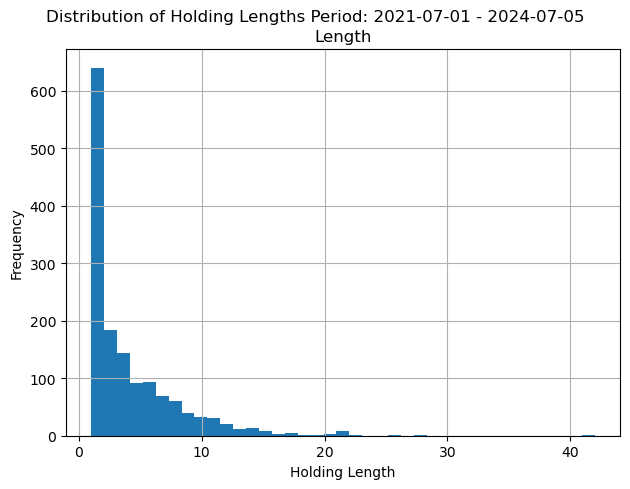

In [77]:
Lengths_24=holdingLengths(df_one_one24_product)
Lengths_24.print_report()
Lengths_24.plot_lengths_hist('Product')

# 2016-2019 Product Strategy

**************************************** Summary: Product Strategy, Period: 2016-02-01 - 2018-10-18 ******************************

	Number of holds: 1451.0

	Mean holding length: 4.212956581667815 days

	Standard deviation of  holding lengths: 3.515011788498876 days

	Minimum holding length: 1.0 days

	Maximum Holding Length: 25.0

	Median holding lengths: 3.0 days



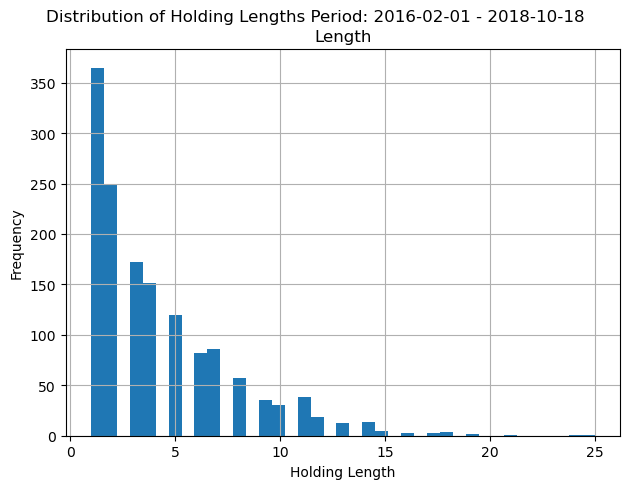

In [79]:
Lengths_19=holdingLengths(df_one_one19_product)
Lengths_19.print_report()
Lengths_19.plot_lengths_hist('Product')

In [81]:
X=Lengths_24.print_individual_stock_lengths()


Stock held with the amount of days held (Product)
ENPH: 9,10,3,1,2,4,12,1,4
NOW: 2,3,4,2,2,6
CRWD: 2,5,3,2,1,5
CMG: 6,2,7,1,4,1
DECK: 9,8,3,2,1,3,1
TSLA: 3,3,17,2,11,10,2,18,2,2,22,12,3
RMD: 2,2,1
TMO: 2
IDXX: 1,8,1
DHR: 1,1,1
NVDA: 4,3,15,2,4,16,9,1,6,6,14,13
FSLR: 8,13,7,14
MTCH: 3,6,9,8,1,7,2
NFLX: 3,12,3,7,11,12,3,3
CHTR: 3,6,2,1,9,4
NKE: 8,1
MRNA: 12,10,1,10,6,3,7,1,1
AMD: 2,2,3,8,7,13,1,9,2,7
KMX: 5,9,4,1,1
HOLX: 3,5
SWKS: 1,1
ORCL: 10,1,4
AAPL: 8,6,1
REGN: 2,5,1,4,2,1,15,1,15
ACN: 4,2
MAA: 9,6,1
UDR: 9,2
WELL: 1,8,1,6,1,1
WAT: 6
ESS: 3,1,2,4
HCA: 4,4
FTNT: 6,2,2,5,1
CPT: 4,3,1,3
ES: 3,6,1
AWK: 11,4,4
EVRG: 10,1,10
EPAM: 1,1,5,6
MPWR: 2,2,9,8
DOC: 1,1,3,2
KR: 4,2,3,4,1,2,3
KO: 1,2,3
PEP: 1
RVTY: 10,2
DUK: 3,2,5
DG: 3,7,8,6,1
COST: 3,1,3,1
LNT: 5
PFE: 3,2,4,5,4
DXCM: 1,4,1,5,6
NRG: 1,3,14,14,6,3,4,15,10,9
KKR: 3,1,10,1
AON: 2,2,1
MSCI: 2,3
WFC: 5,1,5,6,2,3
BEN: 3,2,1
NEE: 13,4,1,1,6,2,9,3,2,6,9,4
EG: 1,5,1,3,2,2,4
AIG: 10,3
AEE: 4,2
ETR: 9,8,2,2
CB: 7,2,2
WST: 2,1,1
A: 3,1
ACGL: 1

In [27]:
tickers = [
    "AAPL", "MSFT", "NVDA", "AMZN", "META", "GOOGL", "LLY", "GOOG", "TSLA", "V",
    "MA", "AVGO", "COST", "NFLX", "AMD", "CRM", "LIN", "ADBE", "MCD", "TXN",
    "NOW", "ISRG", "AMAT", "SPGI", "INTU", "UBER", "BKNG", "TJX", "BSX", "SYK",
    "VRTX", "ADP", "PANW", "BX", "SBUX", "AMT", "ACN", "LRCX", "KLAC", "GE",
    "TMUS", "ANET", "BA", "DIS", "EQIX", "SHW", "ZTS", "CMG", "PLTR", "APH",
    "TDG", "SNPS", "WELL", "CDNS", "MCO", "GEV", "CTAS", "ORLY", "CRWD", "ECL",
    "MRVL", "ADSK", "ROP", "HLT", "MAR", "NKE", "AZO", "APO", "FI", "WDAY",
    "ABNB", "ROST", "TTD", "FTNT", "PWR", "FICO", "WCN", "GWW", "CPRT", "DASH",
    "MPWR", "MSCI", "CL", "PAYX", "YUM", "EW", "IDXX", "HWM", "FAST", "ODFL",
    "IT", "SQ", "HES", "MSI", "VRSK", "VRT", "AON", "EFX", "MNST", "ALNY",
    "DDOG", "COIN", "SNOW", "RMD", "MTD", "VMC", "FANG", "VEEV", "LULU", "CSGP",
    "SLB", "HSY", "HUBS", "ARES", "FSLR", "ANSS", "DXCM", "O", "SBAC", "CHD",
    "TYL", "TTWO", "BR", "BRO", "RBLX", "NET", "TEAM", "WAT", "MRNA", "COO",
    "WST", "SMCI", "ILMN", "TER", "RCL", "LVS", "BKR", "APTV", "LYV", "PINS",
    "ULTA", "EXPE", "MDB", "ZS", "BURL", "MLM", "FDS", "VRSN", "MSTR", "TRGP",
    "LPLA", "TSCO", "APP", "SUI", "ROL", "ENPH", "TW", "VLTO", "DPZ", "JBHT",
    "HEI.A", "GDDY", "STE", "BMRN", "SNAP", "OKTA", "STX", "EL", "EQT", "HAL",
    "USD", "HEI", "CTRA", "TPL", "IBKR", "PODD", "BSY", "ALGN", "FUTURES", "LNGY",
    "INCY", "WMG", "SYM", "ABMD"
]
len(tickers)

184

In [ ]:
def get_breakdown(invest):
    schedule={1: 34/100*invest,
            2: 33/100*invest,
            3: 33/100*invest}
    return schedule
def invest_symmetric(df,ignore_action=True,metrics=['Slope','Corr','Product'],print_summary=True):
    stock_percentages={1:0.65, 2: 0.20,3:0.15}
    D={}
    values={metric:[] for metric in metrics}
    dates={metric: [] for metric in metrics}
    for metric in metrics:
        invest=1000
        value=invest
        data=df[df['Metric']==metric].sort_values(by='End Date')
        invest_dates=data['End Date'].unique()
        for invest_date in invest_dates:
            date_data=data[data['End Date']==invest_date]
            schedule=get_breakdown(value)
            for ind, row in date_data.iterrows():
                if not ignore_action:
                    if row['Action']:
                        if row['Stock_Metric_Sign']:
                            value+=schedule[row['Industry_Rank']]*stock_percentages[row['Stock_Rank']]*row['Percent Gain']
                            
                else:
                    if row['Stock_Metric_Sign']:
                        value+=schedule[row['Industry_Rank']]*stock_percentages[row['Stock_Rank']]*row['Percent Gain']
                        
                if value<0:
                    add_amount=abs(value)+1000
                    value+=add_amount
                    invest+=add_amount
            
            values[metric].append(value)
            dates[metric].append(invest_date)
        D[metric]=[invest,value]
    if print_summary:
        print('Summary')
        print()
        print('{:<25}{:<25}{:<25}'.format('Strategy','Amount Invested', 'Value after Period'))
        for key, value in D.items():
            print('{:<25}{:<25}{:<25}'.format(key,value[0], value[1]))
    return D, values, dates

# Logistic Considerations

**The strategy assumes that you will be able to buy the stock at the closing price of the previous day.  This may not always be the case.  I tested the strategy under the assumption that you would buy at the open and sell at the next days open.  The following analysis makes these assumptions.**

### Open To Open

In [38]:

print('*'*25,'Product 2022-2024 Open to Open','**'*25)
df_20_1_1_product24_open['End Date']=pd.to_datetime(df_20_1_1_product24_open['End Date'])
df_20_1_1_product24_open=df_20_1_1_product24_open[df_20_1_1_product24_open['End Date']>=pd.to_datetime('2022-02-01')]
df_20_1_1_product24_open=df_20_1_1_product24_open.sort_values(by='End Date')
test_df=df_20_1_1_product24_open.dropna(subset=['Percent Gain'])
test_df=filter_by_date(test_df,start_24,end_24)

D, values, dates=spf.invest_symmetric(test_df,metrics=['Product'])


print('*'*25,'Product 2016-2019 Open to Open','**'*25)
df_20_1_1_product19_open['End Date']=pd.to_datetime(df_20_1_1_product19_open['End Date'])

df_20_1_1_product19_open=df_20_1_1_product19_open.sort_values(by='End Date')
test_df=df_20_1_1_product19_open.dropna(subset=['Percent Gain'])
test_df=filter_by_date(test_df,start_19,end_19)

D, values, dates=spf.invest_symmetric(test_df,metrics=['Product'])



print('*'*25,'Pct_Change_Plus 2022-2024 Open to Open','**'*25)
df_20_1_1_pct_plus24_open['End Date']=pd.to_datetime(df_20_1_1_pct_plus24_open['End Date'])
df_20_1_1_pct_plus24_open=df_20_1_1_pct_plus24_open[df_20_1_1_pct_plus24_open['End Date']>=pd.to_datetime('2022-02-01')]
df_20_1_1_pct_plus24_open=df_20_1_1_pct_plus24_open.sort_values(by='End Date')
test_df=df_20_1_1_pct_plus24_open.dropna(subset=['Percent Gain'])
test_df=filter_by_date(test_df,start_24,end_24)

D, values, dates=spf.invest_symmetric(test_df,metrics=['My_Metric'])


print('*'*25,'Pct_Change_Plus 2016-2019 Open to Open','**'*25)
df_20_1_1_pct_plus19_open['End Date']=pd.to_datetime(df_20_1_1_pct_plus19_open['End Date'])

df_20_1_1_pct_plus19_open=df_20_1_1_pct_plus19_open.sort_values(by='End Date')
test_df=df_20_1_1_pct_plus19_open.dropna(subset=['Percent Gain'])
test_df=filter_by_date(test_df,start_19,end_19)

D, values, dates=spf.invest_symmetric(test_df,metrics=['My_Metric'])



************************* Product 2022-2024 Open to Open **************************************************
Summary

Strategy                 Amount Invested          Value after Period       
Product                  1000                     2535.209928930577        
************************* Product 2016-2019 Open to Open **************************************************
Summary

Strategy                 Amount Invested          Value after Period       
Product                  1000                     2331.5415259414344       
************************* Pct_Change_Plus 2022-2024 Open to Open **************************************************
Summary

Strategy                 Amount Invested          Value after Period       
My_Metric                1000                     2503.8589574871658       
************************* Pct_Change_Plus 2016-2019 Open to Open **************************************************
Summary

Strategy                 Amount Invested          Value afte

# Does the rank really matter?
**Above analysis shows that there is a slight positive correlation between the gain rank and the metric rank. However, the sigfificance of the rank is yet to be tested with investment simulations.  The investment results seen just above are using a strategy that invests in stocks in proportion to their metric rank.  Below, I do the same simulations but invest in stocks equally.**

### Equal Weight

In [46]:
print('*'*25,'Product 2022-2024 Open to Open (equal weight)','**'*25)

df_20_1_1_product24_open['End Date']=pd.to_datetime(df_20_1_1_product24_open['End Date'])
df_20_1_1_product24_open=df_20_1_1_product24_open[df_20_1_1_product24_open['End Date']>=pd.to_datetime('2022-02-01')]
df_20_1_1_product24_open=df_20_1_1_product24_open.sort_values(by='End Date')
test_df=df_20_1_1_product24_open.dropna(subset=['Percent Gain'])
test_df=filter_by_date(test_df,start_24,end_24)

D, values, dates=invest_symmetric(test_df,metrics=['Product'])



print('*'*25,'Product 2016-2019 Open to Open (equal weight)','**'*25)
df_20_1_1_product19_open['End Date']=pd.to_datetime(df_20_1_1_product19_open['End Date'])

df_20_1_1_product19_open=df_20_1_1_product19_open.sort_values(by='End Date')
test_df=df_20_1_1_product19_open.dropna(subset=['Percent Gain'])
test_df=filter_by_date(test_df,start_19,end_19)

D, values, dates=invest_symmetric(test_df,metrics=['Product'])

print('*'*25,'Pct_Change_Plus 2022-2024 Open to Open (equal weight)','**'*25)

df_20_1_1_pct_plus19_open['End Date']=pd.to_datetime(df_20_1_1_pct_plus19_open['End Date'])

df_20_1_1_pct_plus19_open=df_20_1_1_pct_plus19_open.sort_values(by='End Date')
test_df=df_20_1_1_pct_plus19_open.dropna(subset=['Percent Gain'])
test_df=filter_by_date(test_df,start_19,end_19)

D, values, dates=invest_symmetric(test_df,metrics=['My_Metric'])

print('*'*25,'Pct_Change_Plus 2016-2019 Open to Open (equal weight)','**'*25)
df_20_1_1_pct_plus24_open['End Date']=pd.to_datetime(df_20_1_1_pct_plus24_open['End Date'])
df_20_1_1_pct_plus24_open=df_20_1_1_pct_plus24_open[df_20_1_1_pct_plus24_open['End Date']>=pd.to_datetime('2022-02-01')]
df_20_1_1_pct_plus24_open=df_20_1_1_pct_plus24_open.sort_values(by='End Date')
test_df=df_20_1_1_pct_plus24_open.dropna(subset=['Percent Gain'])
test_df=filter_by_date(test_df,start_24,end_24)

D, values, dates=invest_symmetric(test_df,metrics=['My_Metric'])

************************* Product 2022-2024 Open to Open (equal weight) **************************************************
Summary

Strategy                 Amount Invested          Value after Period       
Product                  1000                     1722.0889010746248       
************************* Product 2016-2019 Open to Open (equal weight) **************************************************
Summary

Strategy                 Amount Invested          Value after Period       
Product                  1000                     2013.0166437235182       
************************* Pct_Change_Plus 2022-2024 Open to Open (equal weight) **************************************************
Summary

Strategy                 Amount Invested          Value after Period       
My_Metric                1000                     2145.6701788192017       
************************* Pct_Change_Plus 2016-2019 Open to Open (equal weight) **************************************************
Summary



**The My_Metric strategy is less responsive to the metric rank.  Conveivably, you could invest in all stocks equally if the ranking makes it difficult manage logistically.  Below are plots for the My_Metric strategy portfolio vs the market.**

In [57]:
from pandas.tseries.offsets import BDay
def plot_vs_market(df,strategy='Corr',holding_period=10,start_date='2022-01-01',end_date='2024-09-17',ignore_action=True):
    df_voo_reduced=get_voo_for_simulation(holding_period=holding_period,start_date=start_date,end_date=end_date)
    df_voo_reduced.dropna(subset=['Percent Gain'],inplace=True)
    invest=1000
    value=invest
    dates_voo=[]
    values_voo=[]
    data_D,values, dates=invest_symmetric(df,ignore_action=ignore_action,metrics=[strategy])
    voo_D,values_voo,dates_voo=invest_symmetric(df_voo_reduced,ignore_action=True,metrics=['VOO'])
                        
                                          
    
    fig, ax=plt.subplots()
    ax.scatter(x=dates[strategy],y=values[strategy], color='blue',label='Portfolio')
    ax.scatter(x=dates_voo['VOO'],y=values_voo['VOO'],color='red',label='Market')
    ax.tick_params(axis='x', rotation=45)
    fig.suptitle(f'Portfolio vs. Market\n Holding Period:{holding_period} days\n{strategy}')
    plt.legend()
    plt.show()
def get_voo(start_date, end_date, holding_period=1):
    voo = yf.Ticker("VOO")
    df_voo = voo.history(start=start_date, end=end_date).reset_index()
    df_voo['Date'] = pd.to_datetime(df_voo['Date']).dt.tz_localize(None)
    
    df_voo.sort_values(by='Date', inplace=True)
    df_voo['Pct_Change'] = (df_voo['Close'].shift(-1*holding_period) - df_voo['Close']) / df_voo['Close']
    return df_voo.dropna(subset=['Pct_Change'])


def get_voo_for_simulation(holding_period, start_date, end_date):
    # Convert end_date to datetime and add one business day
    end_date = pd.to_datetime(end_date) + BDay(2)
    
    df_voo = pd.DataFrame()
    for ind_rank in range(1, 4):
        for stock_rank in range(1, 4):
            add_df = get_voo(start_date=start_date, end_date=end_date, holding_period=holding_period)
            add_df['Metric'] = 'VOO'
            add_df['Stock_Metric_Sign'] = True
            add_df['Stock_Rank'] = stock_rank
            add_df['Industry_Rank'] = ind_rank
            df_voo = pd.concat([df_voo, add_df])
    
    df_voo['Percent Gain'] = df_voo['Pct_Change']
    df_voo['End Date'] = df_voo['Date']
    df_voo = df_voo.sort_values(by=['Date', 'Industry_Rank', 'Stock_Rank'])
    
    # Remove the extra day we added at the beginning
    df_voo = df_voo[df_voo['Date'] <= pd.to_datetime(end_date) - BDay(1)]
    
    return df_voo

# Plots for My_Metric Portfolio vs the Market Investing in stocks equally and buying and selling at the Open.

## 2016-2019

Summary

Strategy                 Amount Invested          Value after Period       
My_Metric                1000                     2145.6701788192017       
Summary

Strategy                 Amount Invested          Value after Period       
VOO                      1000                     1508.4857807515777       


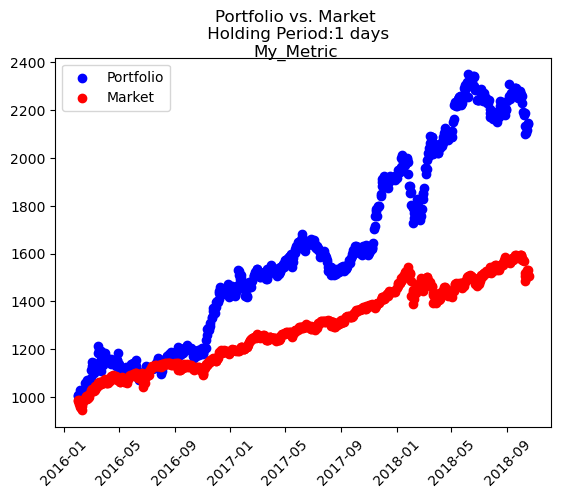

In [65]:

plot_vs_market(df_20_1_1_pct_plus19_open.dropna(subset=['Percent Gain']),strategy='My_Metric',holding_period=1,start_date=start_19,end_date=end_19)



## 2022-2024

Summary

Strategy                 Amount Invested          Value after Period       
My_Metric                1000                     2278.8202851112865       
Summary

Strategy                 Amount Invested          Value after Period       
VOO                      1000                     1274.7750062474931       


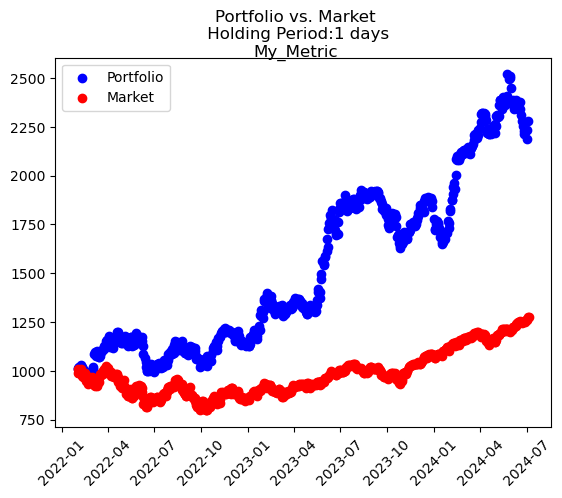

In [69]:

plot_vs_market(df_20_1_1_pct_plus24_open.dropna(subset=['Percent Gain']),strategy='My_Metric',holding_period=1,start_date=start_24,end_date=end_24)
